Landau parameters
a_Q: -0.303465
b_Q: 0.261635
c_Q: 0.000001
a_P: 0.000000
b_P: 1.590659
c_P: -0.951420
d_P: 0.275763
e_P: -0.047799
f_P: 0.000001
a_PQ: -0.848817
b_PQ: 0.342470
c_PQ: -0.218259
d_PQ: 0.077008
e_PQ: 0.105391
f_PQ: 0.000002
a_2Q: 1.441130
b_2Q: -0.312749
c_2Q: 0.040445
d_2Q: 0.023008
a_P2Q: -0.003858
b_P2Q: 0.236628
c_P2Q: -0.753989
d_P2Q: -0.085867
e_P2Q: 0.410157
f_P2Q: 0.000001
chemical potential parameters in meV/me^-xA^-3:
 mu: 9.349231
 mu': 0.174599
Ginzburg parameters in meV/A^3:
 s: 6.639865
 r: 1026.924183
4.59179167153945 1.6769227380915965
70.89770905284503 16.596550502166888


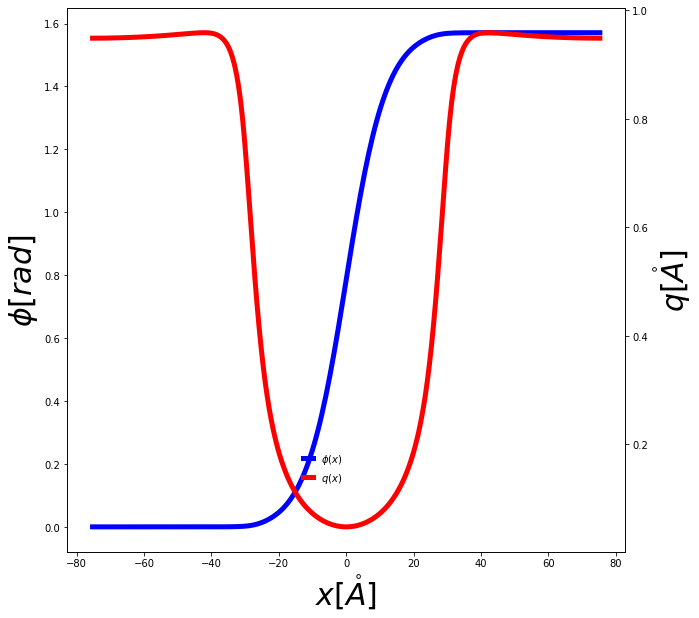

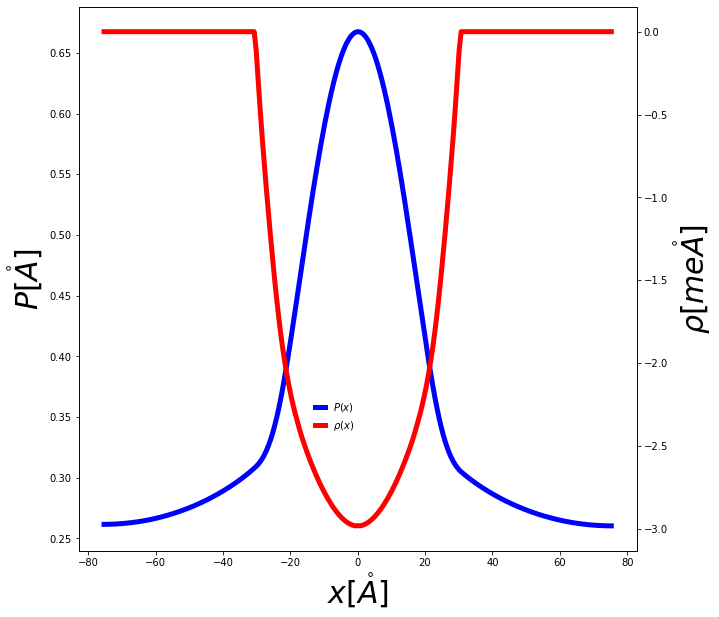

E_init: 3.995938 | charge_init: -135.540000
E: -1.714932 	|	 dE: -5.710870 	|	 total_charge: -135.539100


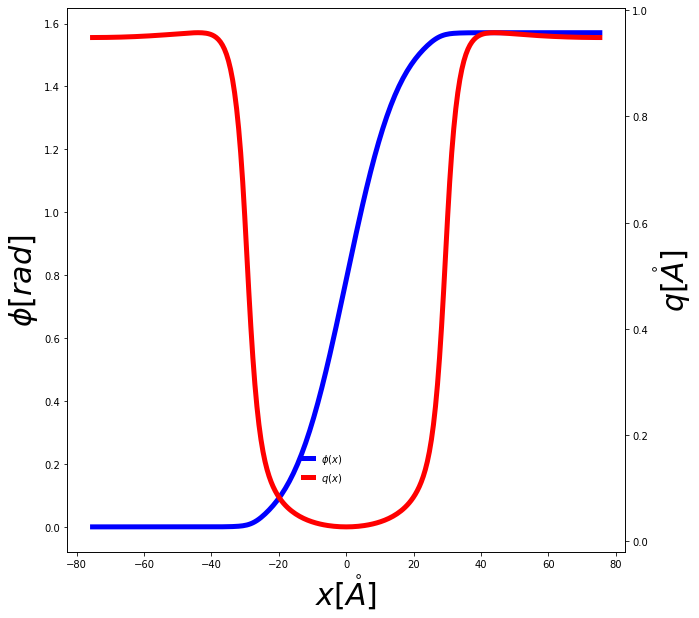

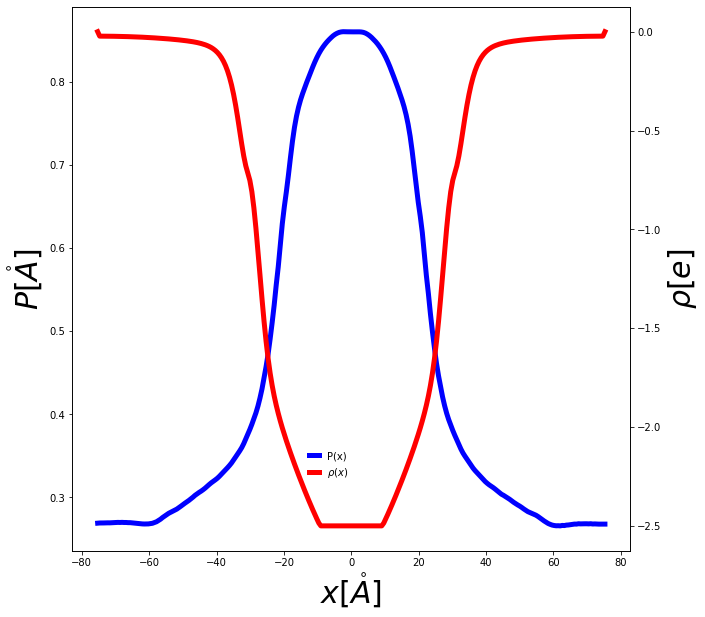

E: -3.484233 	|	 dE: -1.769300 	|	 total_charge: -135.539100


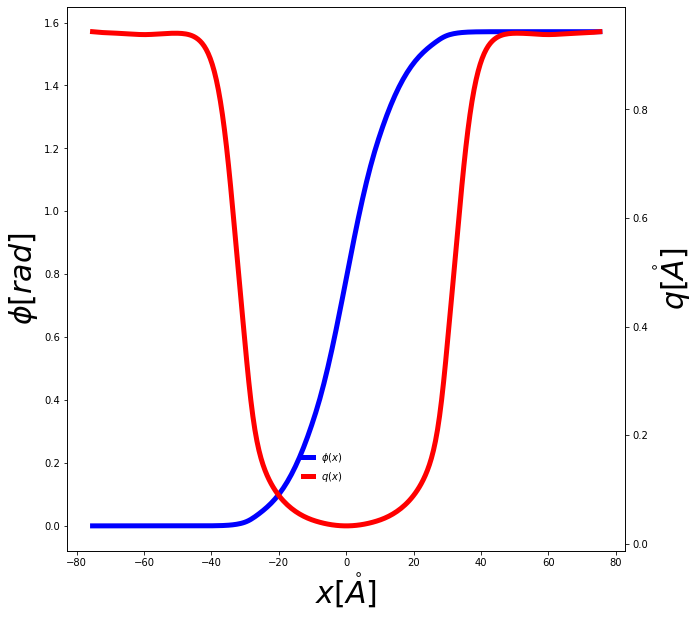

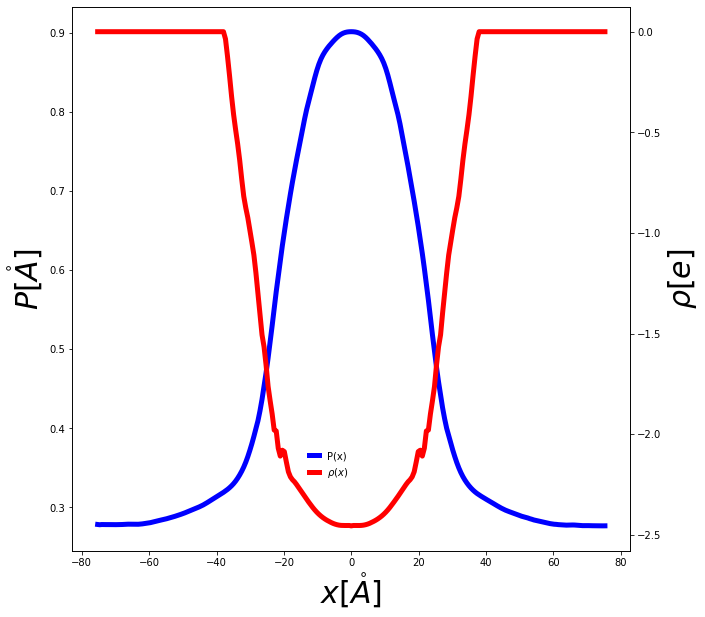

E: -3.739217 	|	 dE: -0.254984 	|	 total_charge: -135.539100


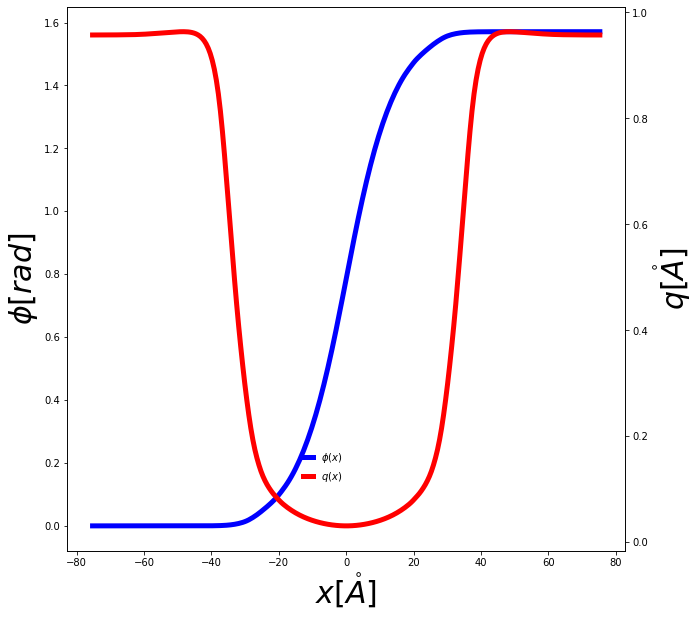

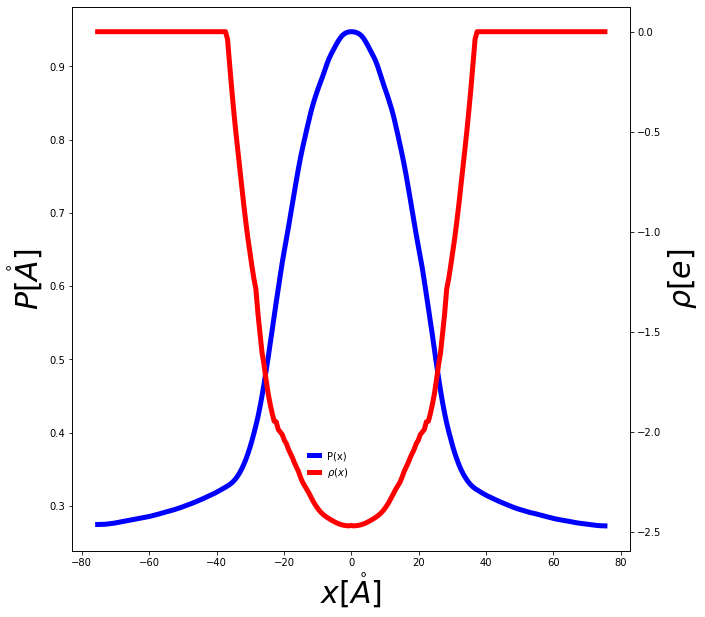

E: -3.780705 	|	 dE: -0.041488 	|	 total_charge: -135.539100


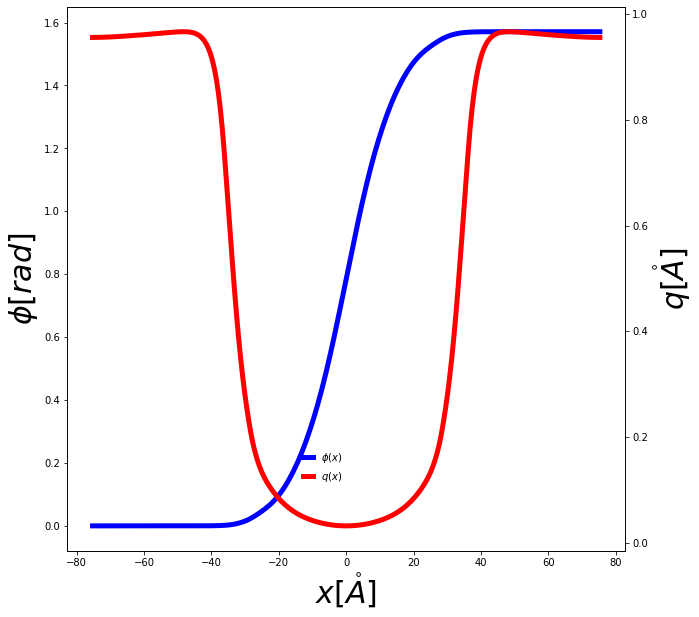

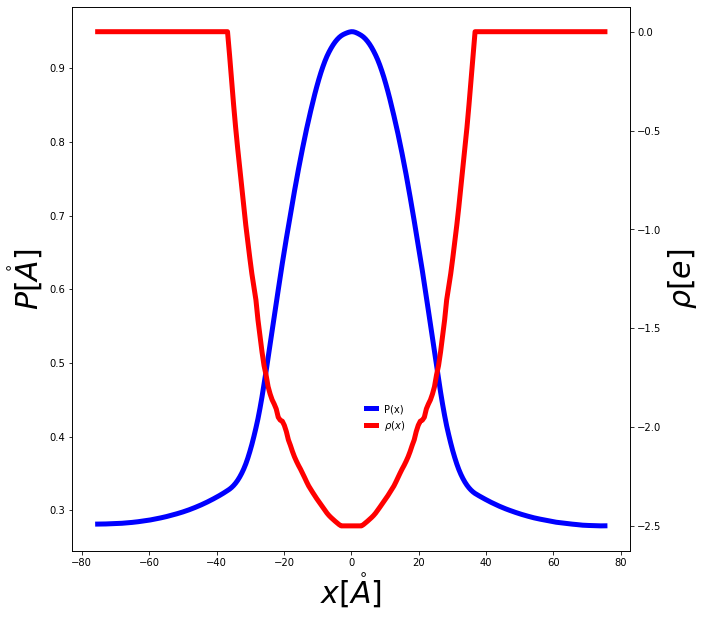

E: -3.791693 	|	 dE: -0.010988 	|	 total_charge: -135.539100


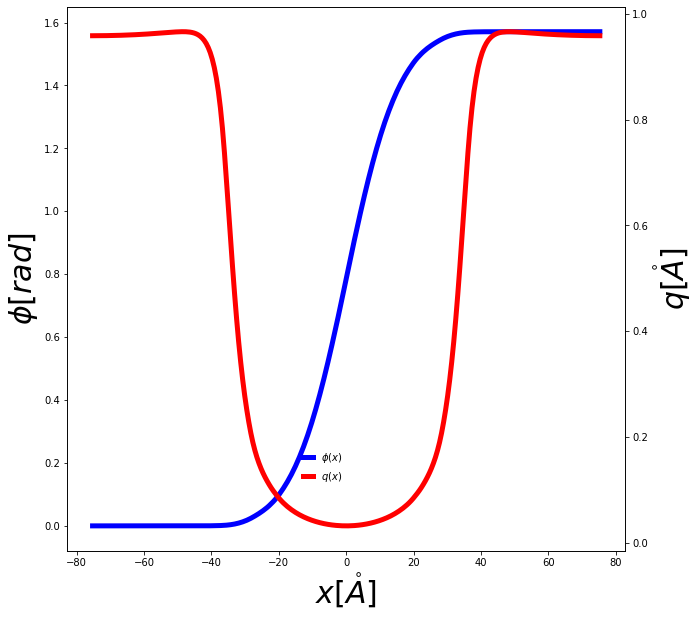

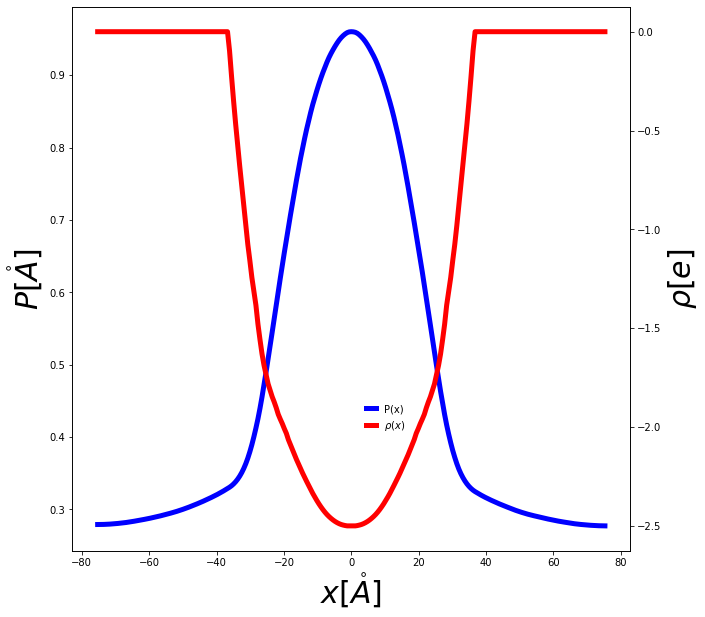

E: -3.796776 	|	 dE: -0.005083 	|	 total_charge: -135.539100


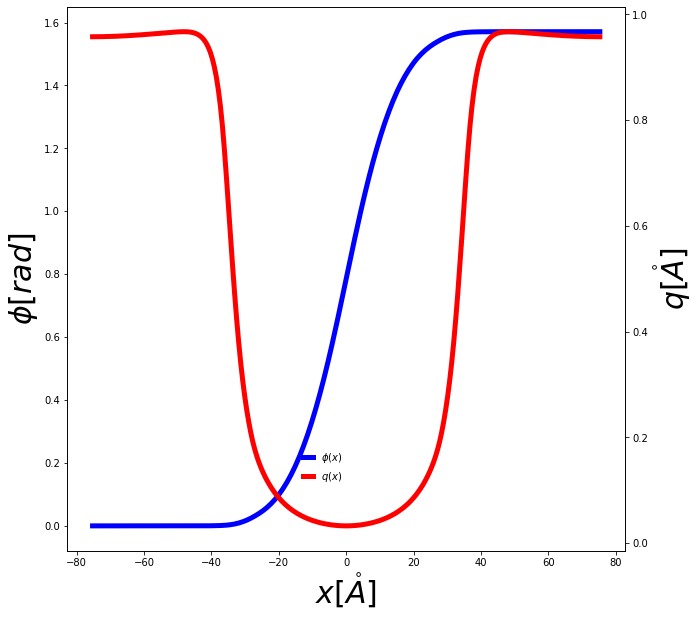

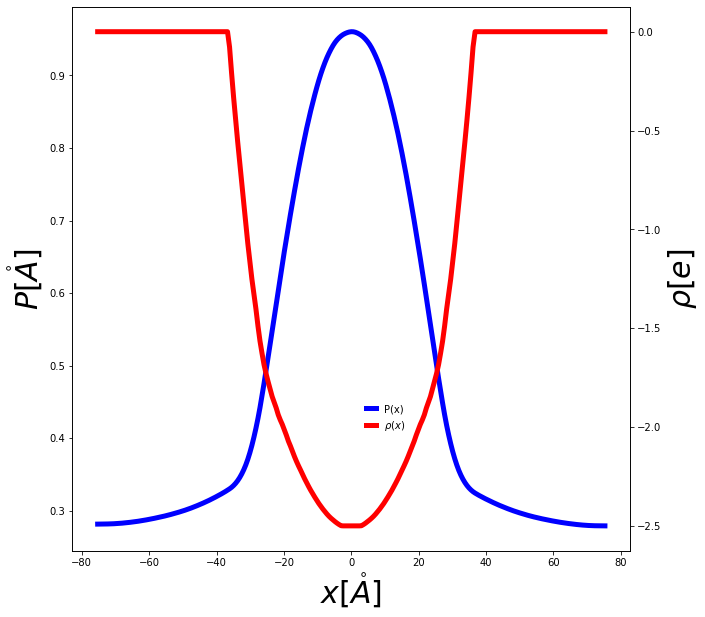

E: -3.799972 	|	 dE: -0.003196 	|	 total_charge: -135.539100


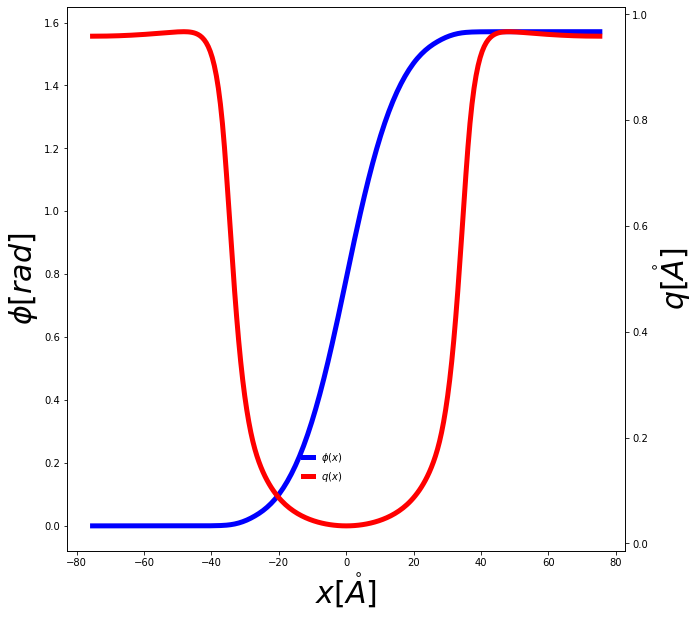

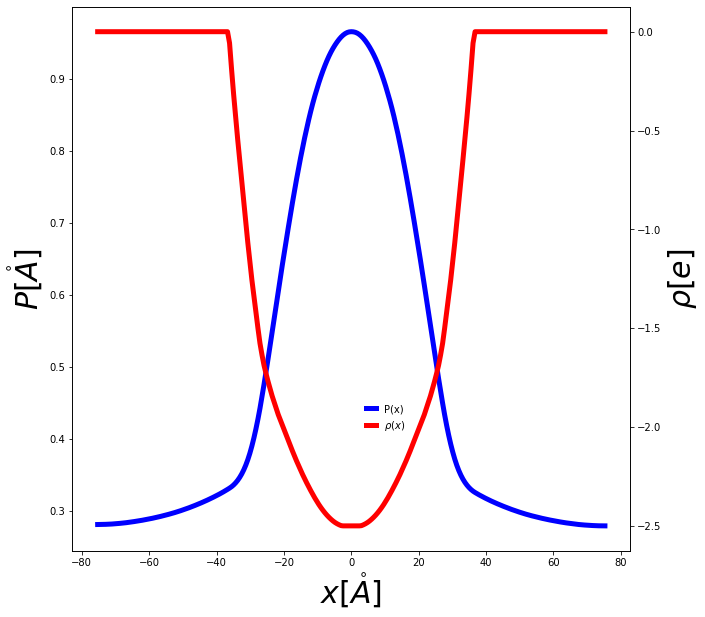

E: -3.802077 	|	 dE: -0.002105 	|	 total_charge: -135.539100


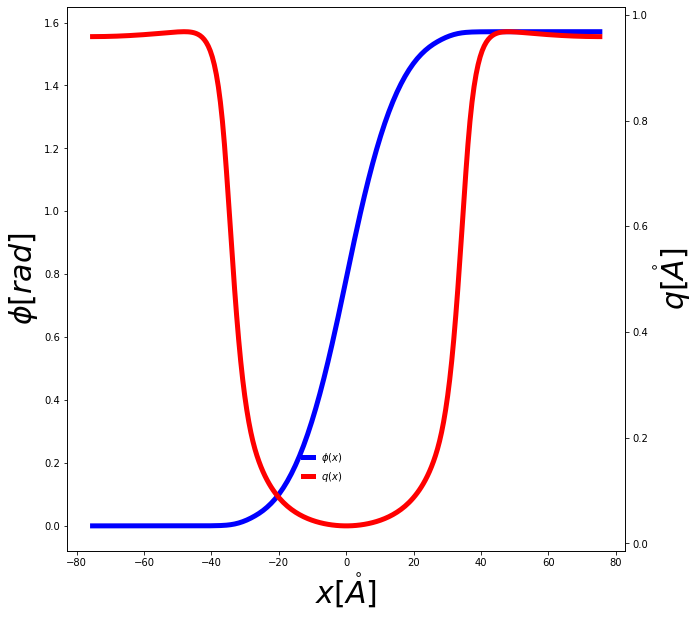

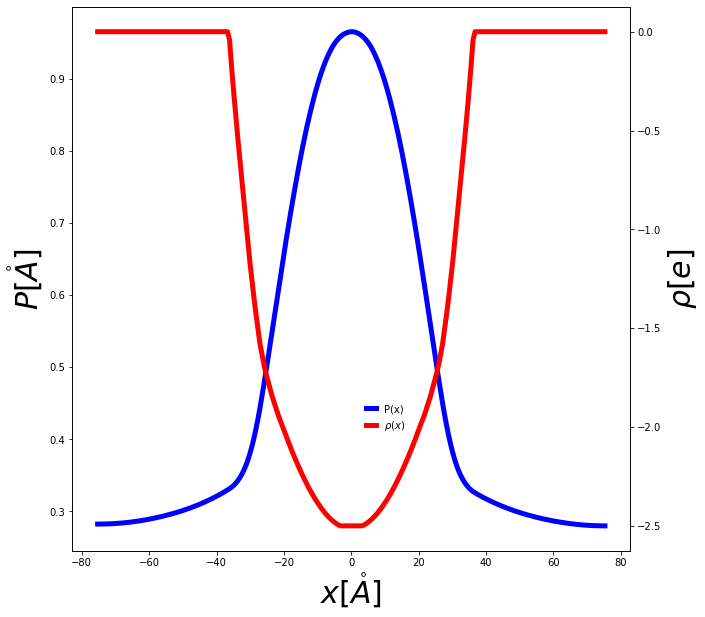

E: -3.803524 	|	 dE: -0.001447 	|	 total_charge: -135.539100


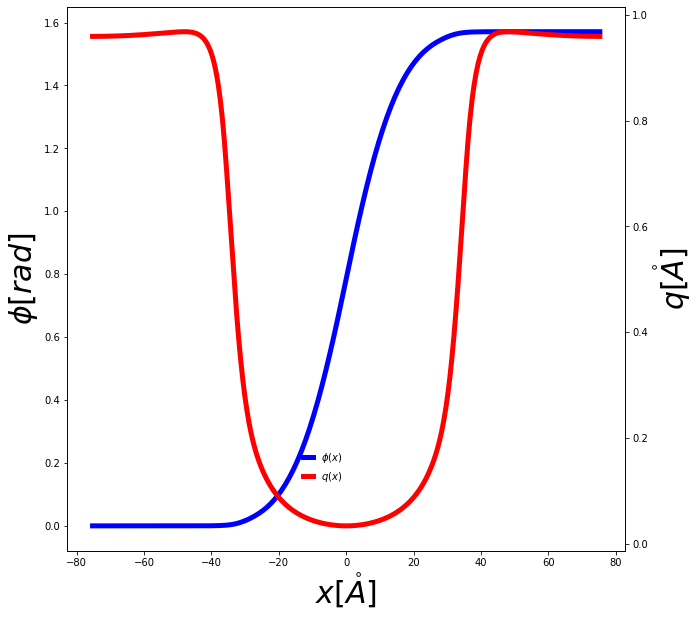

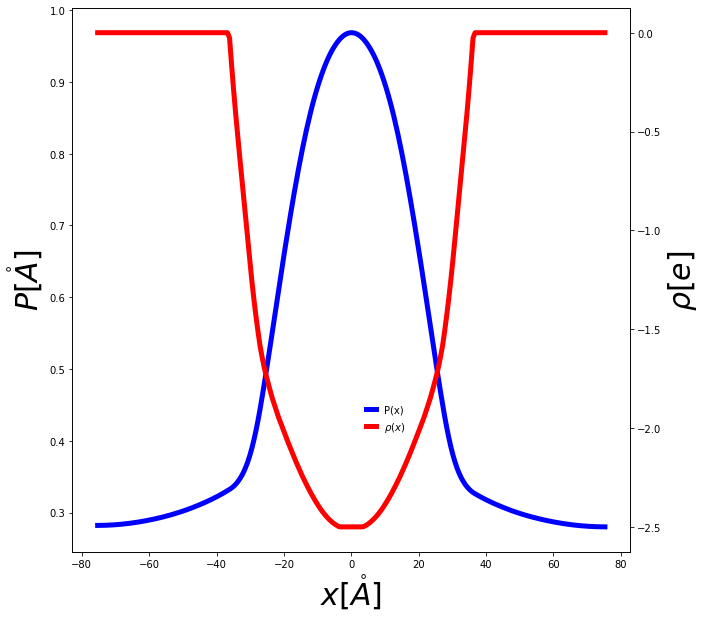

E: -3.804638 	|	 dE: -0.001114 	|	 total_charge: -135.539100


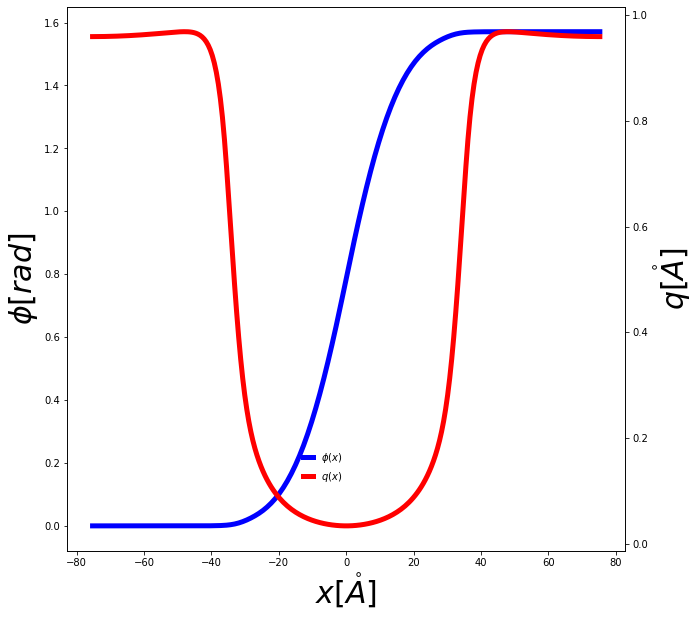

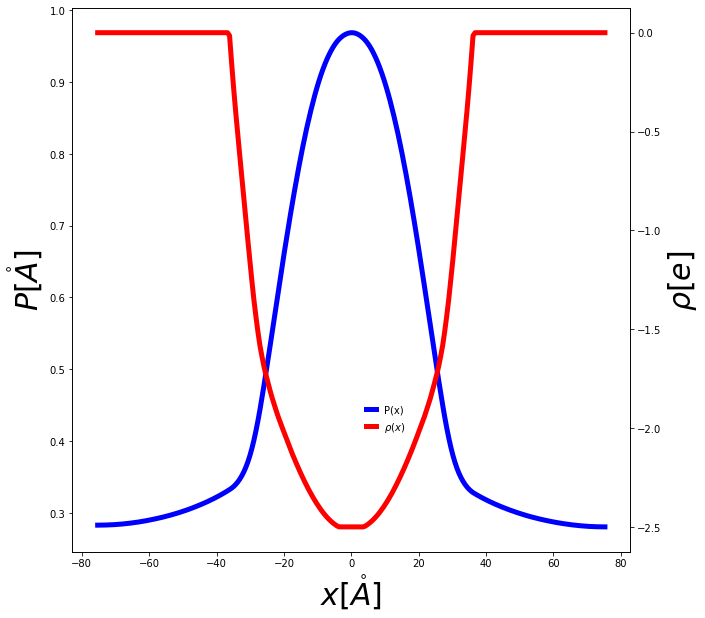

E: -3.805448 	|	 dE: -0.000810 	|	 total_charge: -135.539100


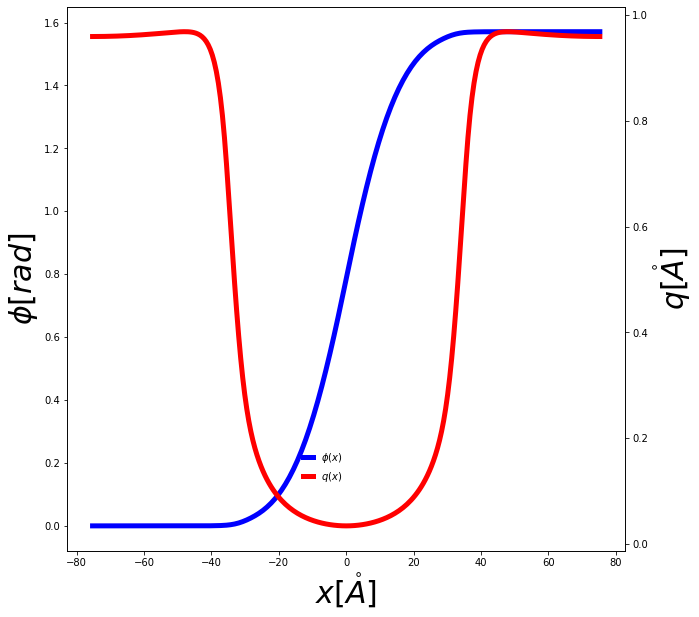

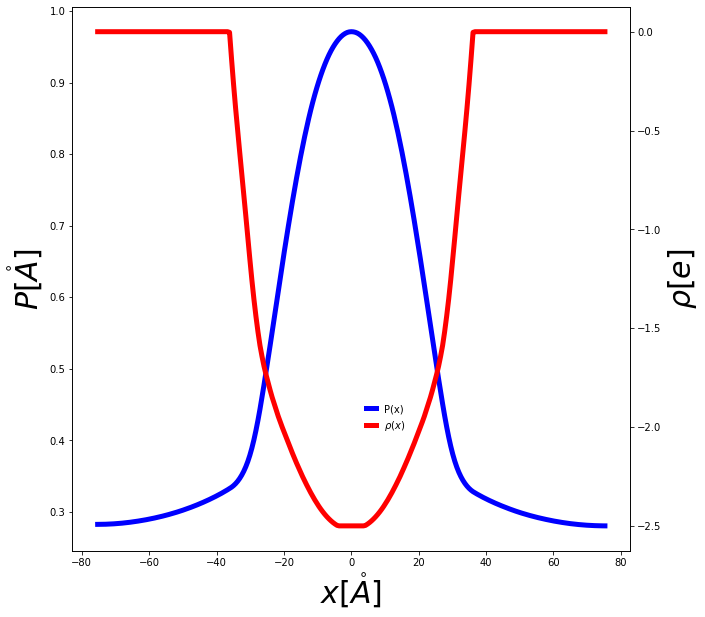

E: -3.806048 	|	 dE: -0.000600 	|	 total_charge: -135.539100


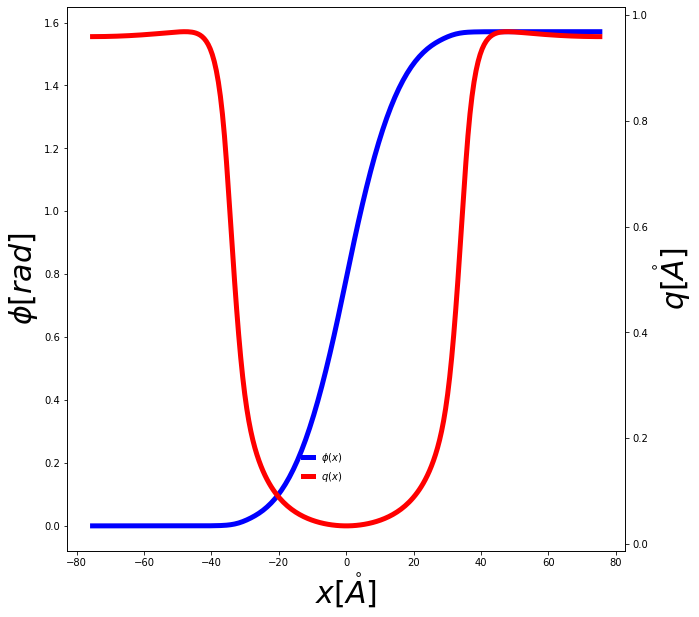

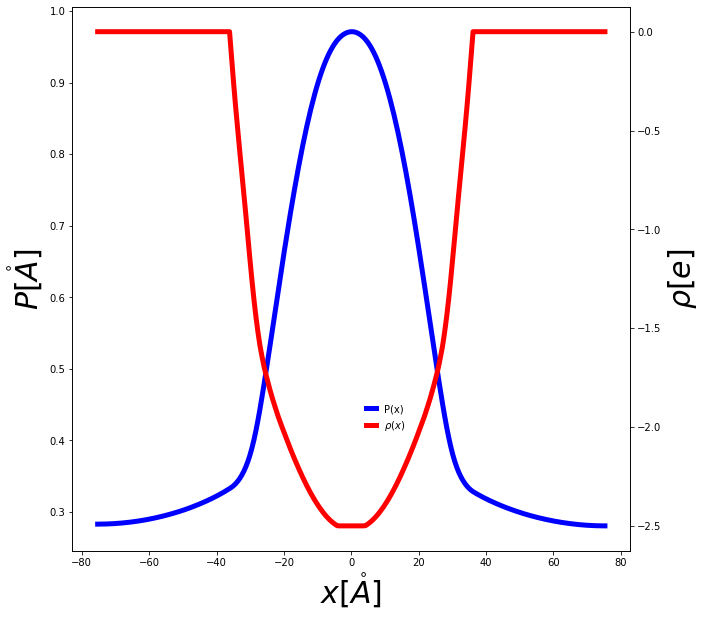

E: -3.806456 	|	 dE: -0.000408 	|	 total_charge: -135.539100


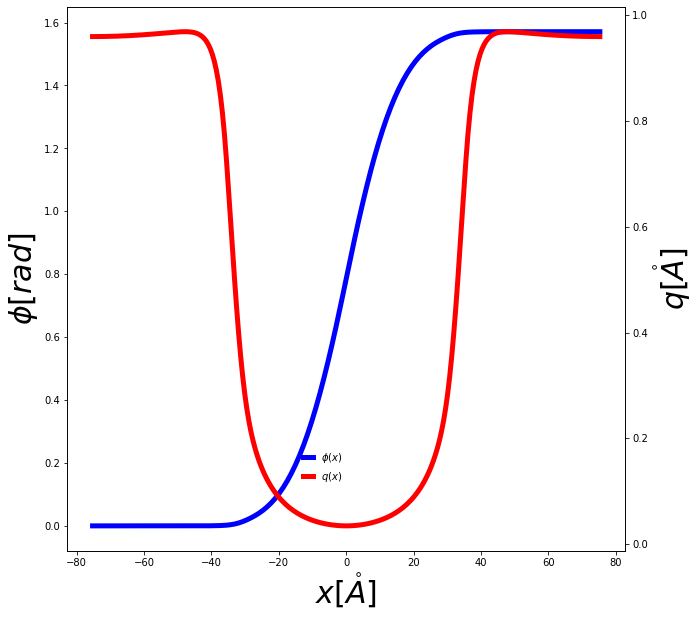

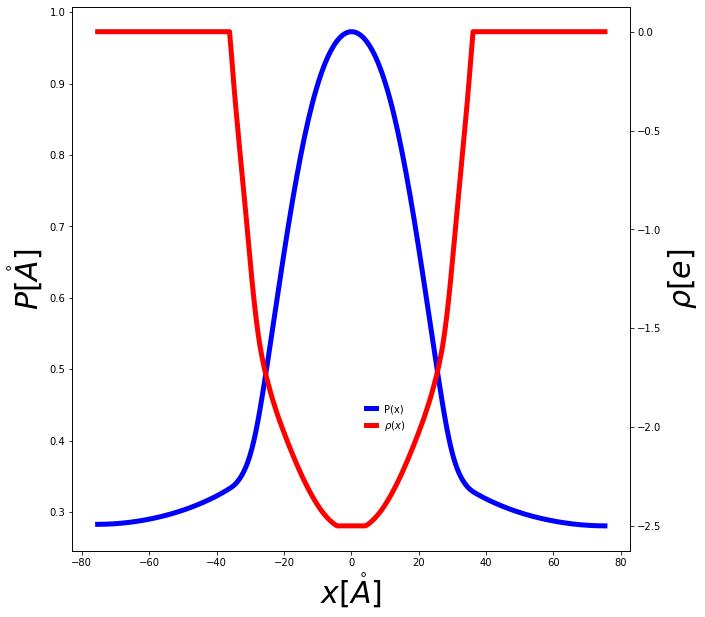

E: -3.806726 	|	 dE: -0.000269 	|	 total_charge: -135.539100


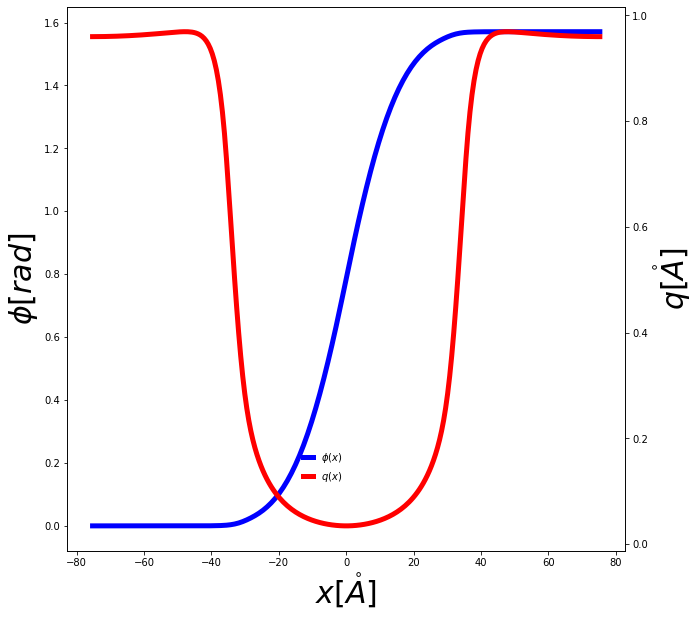

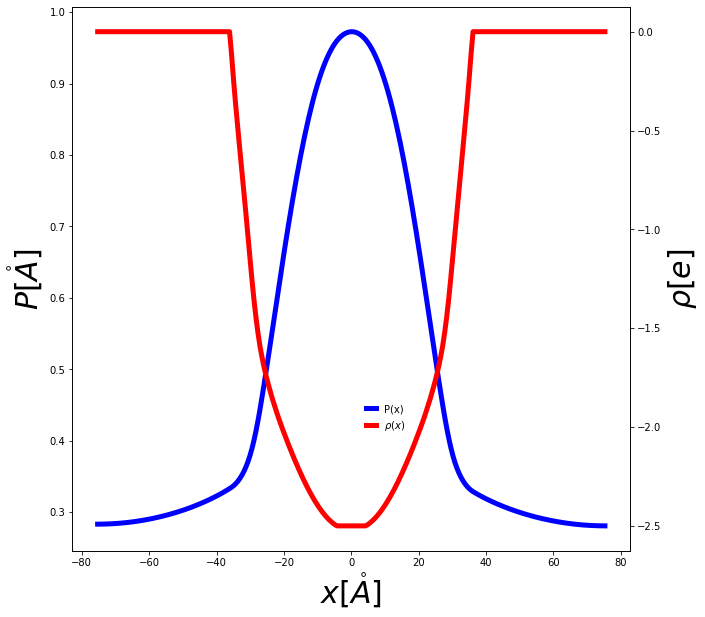

E: -3.806918 	|	 dE: -0.000192 	|	 total_charge: -135.539100


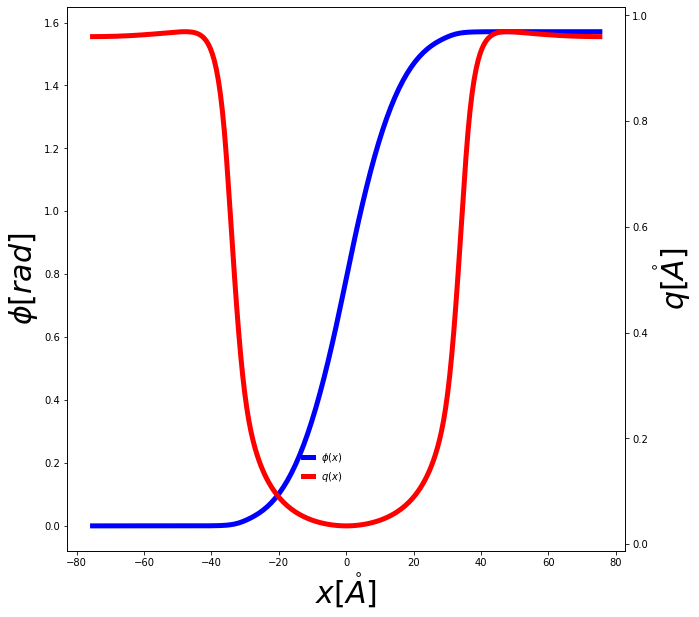

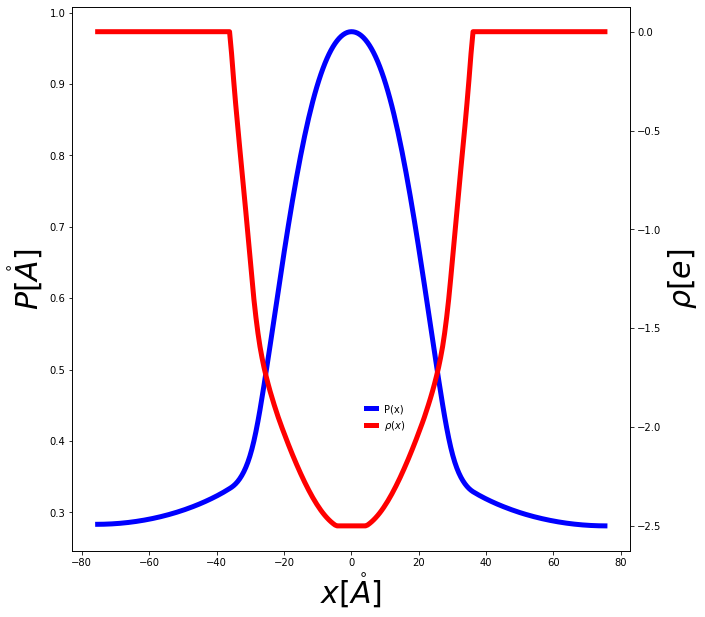

E: -3.807053 	|	 dE: -0.000135 	|	 total_charge: -135.539100


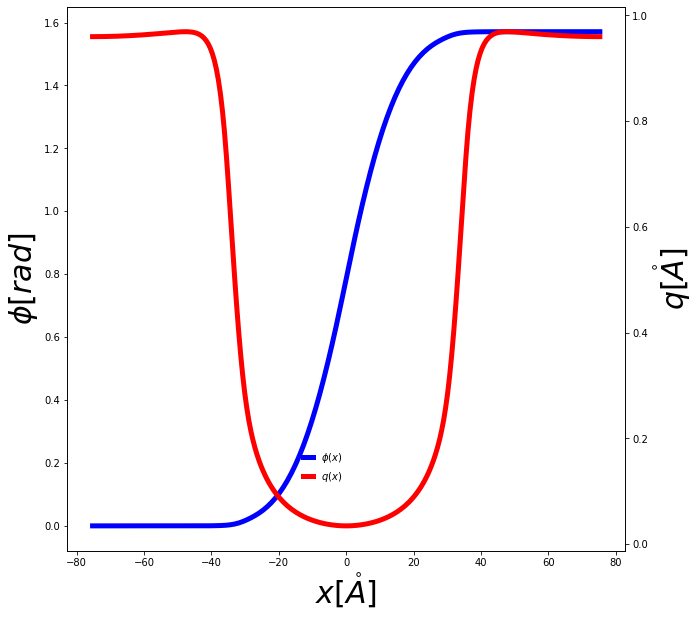

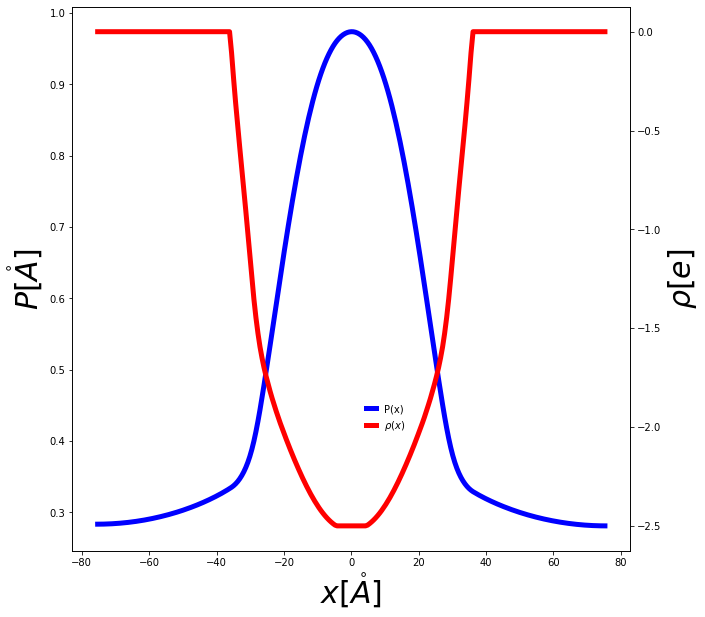

E: -3.807146 	|	 dE: -0.000093 	|	 total_charge: -135.539100


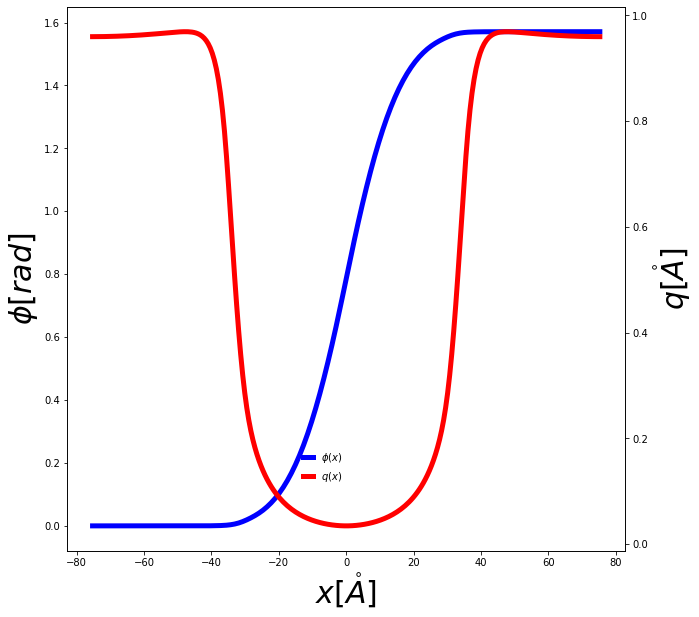

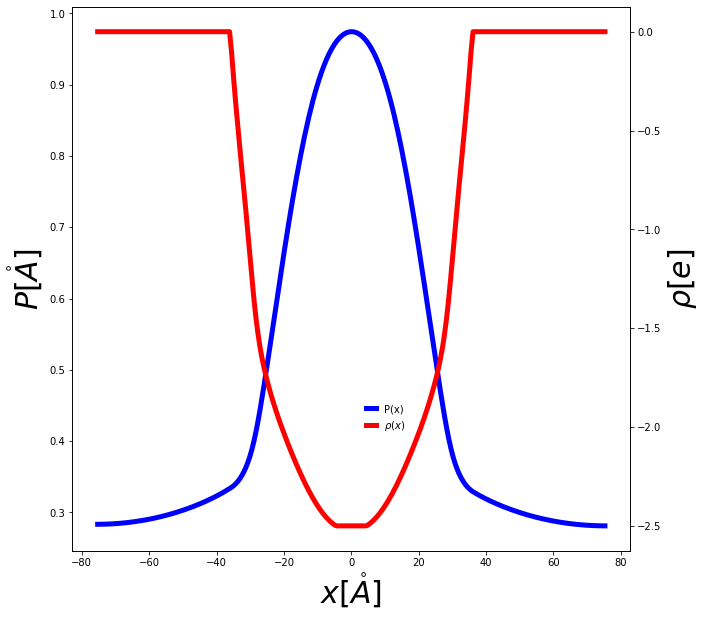

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy as sc
from scipy import optimize
from mpl_toolkits.mplot3d import Axes3D
import random as rnd
from scipy.optimize import minimize
import scipy.linalg
from scipy.optimize import Bounds
import multiprocessing
import sys

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

#calculate Landau parameters 
Landau = True
#calculate change of parameters upon doping
charge = True
#calculate chemical potential
chempot = True
#calculate Ginzburg parameter
Ginzburg = True
#calculating analytical wall
analytical = False
#calculating numerical wall
numerical = True


#prefix for all data files
prefix = "n251_e9E-1"

#set to true to calculate data files of plots with specified prefix
data_write = True

#set to True to show simple plots of data with specified prefix
data_read = False

#if plot_verbosity = 1 additional simple plots of all parameter fits are shown
plot_verbosity = 0

#numerical minimization parameters
#number of points in grid (needs to be odd)
nsteps = 251
#length between grid points
dx = 0.6
#amplitude of initial uniform P and Q
P_init = 0.22994
q1_init = 0.91271
q2_init = 0.91271
#value of initial uniform rho in meA^-3
rho_init = -9e-1
#scf convergence threshold. It's the change in planar energy density in meV
#total energy can be obtained by multiplying with plane area which is a constant value
scf_conv = 1e-4
#tolerance for charge integral
charge_prec = abs(rho_init/1000)
#scf mixing factor
scf_mix = 1.0
file_init = "DATA/DOMAIN_WALLS/n251_e6E-1.numerical"

#parallel execution of all types of walls minimizations (not working on Windows)
parallel = False

#volume of unit cell in angstrom cubed of 32 atom cell
volume_32 = 7.3236460686 * 7.7495899200 * 7.3236460686

#volume of unit cell in angstrom cubed of 16 atom cell
volume_16 = 5.177959919 * 5.177959919 * 7.7496299744


#________________________________________LANDAU______________________________________________#
#____________________________________________________________________________________________#
ry_to_mev = 13.605698066 * 1000
ry_to_thz = 3289.845
thz_to_mev = 0.00414E3
aut_to_a = 0.5291772083

if Landau and data_write:    
   
    #_________________________LOADING AND PREPARING ENERGY FILES__________________________________#
    E_Q_unstrained = np.loadtxt("DATA/ENERGIES/energies_Q_unstrained.txt")[::2]
    E_P_unstrained = np.loadtxt("DATA/ENERGIES/energies_P_unstrained.txt")[::2]
    
    E_PQ_2_unstrained = np.loadtxt("DATA/ENERGIES/energies_PQ_2_unstrained.txt")[::2]
    E_PQ_3_unstrained = np.loadtxt("DATA/ENERGIES/energies_PQ_3_unstrained.txt")[::2]
    E_PQ_4_unstrained = np.loadtxt("DATA/ENERGIES/energies_PQ_4_unstrained.txt")[::2]
    E_PQ_5_unstrained = np.loadtxt("DATA/ENERGIES/energies_PQ_5_unstrained.txt")[::2]
    E_PQ_6_unstrained = np.loadtxt("DATA/ENERGIES/energies_PQ_6_unstrained.txt")[::2]
    E_PQ_7_unstrained = np.loadtxt("DATA/ENERGIES/energies_PQ_7_unstrained.txt")[::2]
    E_PQ_8_unstrained = np.loadtxt("DATA/ENERGIES/energies_PQ_8_unstrained.txt")[::2]
    E_PQ_Pbcn_unstrained = np.loadtxt("DATA/ENERGIES/energies_PQ_Pbcn_unstrained.txt")[::2]
    
    E_P2Q_unstrained = np.loadtxt("DATA/ENERGIES/energies_P2Q_unstrained.txt")
    E_P2Q_2_unstrained = np.loadtxt("DATA/ENERGIES/energies_P2Q_2_unstrained.txt")
    E_P2Q_3_unstrained = np.loadtxt("DATA/ENERGIES/energies_P2Q_3_unstrained.txt")
    E_P2Q_4_unstrained = np.loadtxt("DATA/ENERGIES/energies_P2Q_4_unstrained.txt")
    E_P2Q_5_unstrained = np.loadtxt("DATA/ENERGIES/energies_P2Q_5_unstrained.txt")
    E_P2Q_6_unstrained = np.loadtxt("DATA/ENERGIES/energies_P2Q_6_unstrained.txt")
    E_P2Q_7_unstrained = np.loadtxt("DATA/ENERGIES/energies_P2Q_7_unstrained.txt")
    E_P2Q_8_unstrained = np.loadtxt("DATA/ENERGIES/energies_P2Q_8_unstrained.txt")
        
    #subtract the P4ncc bulk energy (amplitude = 0)
    E_bulk = E_Q_unstrained[0,1]
    E_Q_unstrained = E_Q_unstrained[:,1] - E_bulk
    E_P_unstrained = E_P_unstrained[:,1] - E_bulk
    
    E_PQ_2_unstrained = E_PQ_2_unstrained[:,1] - E_bulk
    E_PQ_3_unstrained = E_PQ_3_unstrained[:,1] - E_bulk
    E_PQ_4_unstrained = E_PQ_4_unstrained[:,1] - E_bulk
    E_PQ_5_unstrained = E_PQ_5_unstrained[:,1] - E_bulk
    E_PQ_6_unstrained = E_PQ_6_unstrained[:,1] - E_bulk
    E_PQ_7_unstrained = E_PQ_7_unstrained[:,1] - E_bulk
    E_PQ_8_unstrained = E_PQ_8_unstrained[:,1] - E_bulk
    E_PQ_Pbcn_unstrained = E_PQ_Pbcn_unstrained[:,1] - E_bulk
    
    E_P2Q_unstrained = E_P2Q_unstrained[:,1] - E_bulk
    E_P2Q_2_unstrained = E_P2Q_2_unstrained[:,1] - E_bulk
    E_P2Q_3_unstrained = E_P2Q_3_unstrained[:,1] - E_bulk
    E_P2Q_4_unstrained = E_P2Q_4_unstrained[:,1] - E_bulk
    E_P2Q_5_unstrained = E_P2Q_5_unstrained[:,1] - E_bulk
    E_P2Q_6_unstrained = E_P2Q_6_unstrained[:,1] - E_bulk
    E_P2Q_7_unstrained = E_P2Q_7_unstrained[:,1] - E_bulk
    E_P2Q_8_unstrained = E_P2Q_8_unstrained[:,1] - E_bulk
    
    #energy unit conversion from Ry to meV and volume normalization
    E_Q_unstrained *= ry_to_mev / volume_32
    E_P_unstrained *= ry_to_mev / volume_32
    
    E_PQ_2_unstrained *= ry_to_mev / volume_32
    E_PQ_3_unstrained *= ry_to_mev / volume_32
    E_PQ_4_unstrained *= ry_to_mev / volume_32
    E_PQ_5_unstrained *= ry_to_mev / volume_32
    E_PQ_6_unstrained *= ry_to_mev / volume_32
    E_PQ_7_unstrained *= ry_to_mev / volume_32
    E_PQ_8_unstrained *= ry_to_mev / volume_32
    E_PQ_Pbcn_unstrained *= ry_to_mev / volume_32
    
    E_P2Q_unstrained *= ry_to_mev / volume_32
    E_P2Q_2_unstrained *= ry_to_mev / volume_32
    E_P2Q_3_unstrained *= ry_to_mev / volume_32
    E_P2Q_4_unstrained *= ry_to_mev / volume_32
    E_P2Q_5_unstrained *= ry_to_mev / volume_32
    E_P2Q_6_unstrained *= ry_to_mev / volume_32
    E_P2Q_7_unstrained *= ry_to_mev / volume_32
    E_P2Q_8_unstrained *= ry_to_mev / volume_32
    
    #maximum amplitudes in curves
    Q_max = 1.20136
    P_max = 0.84857*np.sqrt(2)
    
    PQ_2_max = (0.15252, 1.20136)
    PQ_3_max = (0.45026, 1.20136)
    PQ_4_max = (0.59927, 1.20136)
    PQ_5_max = (0.74800, 1.20136)
    PQ_6_max = (1.18409, 0.29993)
    PQ_7_max = (1.18409, 0.60016)
    PQ_8_max = (1.18409,  0.90007)
    PQ_Pbcn_max = (0.30249, 1.20136)
    
    P2Q_max = (0.15376, 1.69897/np.sqrt(2), 1.69897/np.sqrt(2))
    P2Q_2_max = (0.30124, 1.20135, 0.900066)
    P2Q_3_max = (0.44657, 1.20136, 0.799985)
    P2Q_4_max = (0.59314, 1.20136, 0.700046)
    P2Q_5_max = (0.73943, 1.20136, 0.600164)
    P2Q_6_max = (1.16841, 0.29995, 0.719815)
    P2Q_7_max = (1.16841, 0.60017, 0.200064)
    P2Q_8_max = (1.16841, 0.90006, 0.224943)
        
    #_________________________COMPUTING LANDAU PARAMETERS__________________________________#

    #________________LANDAU Q UNSTRAINED_________________#
    #index of last point to be included in fitting
    imax = 21
    
    #parameters of highest order must not be negative
    bnds = ([-np.inf, -np.inf, 1e-6], np.inf)
    
    #includes terms up to 8th order for Q terms
    def Landau_poly(Q, a_Q, b_Q, c_Q):        
        return a_Q*Q**2 + \
               b_Q*Q**4 + \
               c_Q*Q**6  
        
    Q = np.linspace(0, Q_max, 21)[0:imax]
    E = E_Q_unstrained[0:imax]
    
    popt_Landau, pcov_Landau= sc.optimize.curve_fit(Landau_poly, Q, E, bounds=bnds)
    
    a_Q_ = popt_Landau[0]
    b_Q_ = popt_Landau[1]
    c_Q_ = popt_Landau[2]

    if plot_verbosity == 1:
        plt.figure(1)
        plt.title("Q")
        plt.plot(np.linspace(0,Q_max,21), Landau_poly(np.linspace(0,Q_max,21), *popt_Landau))
        plt.scatter(np.linspace(0,Q_max,21), E_Q_unstrained)

    
    #________________LANDAU P_________________#
    imax = 21
    
    #linear parameter of P must not be negative
    bnds = ([0, -20, -20, -20, -20, 1e-6,], 20)
    
    #includes terms up to 8th order for P
    def Landau_poly(P, a_P, b_P, c_P, d_P, e_P, f_P):
        return a_P*P + \
               b_P*P**2 + \
               c_P*P**3 + \
               d_P*P**4 + \
               e_P*P**5 + \
               f_P*P**6 
    
    P = np.linspace(0, P_max, 21)[0:imax]

    E = E_P_unstrained[0:imax]

    popt_Landau, pcov_Landau= sc.optimize.curve_fit(Landau_poly, P, E, bounds=bnds)
    
    a_P_ = popt_Landau[0]
    b_P_ = popt_Landau[1]
    c_P_ = popt_Landau[2]
    d_P_ = popt_Landau[3]
    e_P_ = popt_Landau[4]
    f_P_ = popt_Landau[5]
    
    if plot_verbosity == 1:
        plt.figure(11)
        plt.title("P")
        plt.plot(np.linspace(0, P_max, 21), Landau_poly(np.linspace(0, P_max, 21), *popt_Landau))
        plt.scatter(np.linspace(0, P_max, 21), E_P_unstrained)             
        
    #________________LANDAU PQ_________________#
    imax = 21
    
    bnds = ([-20, -20, -20, -20, 1e-6, 1e-6], 20)
    
    #includes terms up to 6th order for PQ terms
    def Landau_poly(PQ, a_PQ, b_PQ, c_PQ, d_PQ, e_PQ, f_PQ):
        P, Q = PQ
        return a_Q_*Q**2 + \
               b_Q_*Q**4 + \
               c_Q_*Q**6 + \
               a_P_*P + \
               b_P_*P**2 + \
               c_P_*P**3 + \
               d_P_*P**4 + \
               e_P_*P**5 + \
               f_P_*P**6 + \
               a_PQ*P*Q**2 + \
               b_PQ*P**2*Q**2 + \
               c_PQ*P**3*Q**2 + \
               d_PQ*P*Q**4 + \
               e_PQ*P**4*Q**2 + \
               f_PQ*P**2*Q**4
    
    P = np.zeros(0)
    P = np.append(P, np.linspace(0, PQ_2_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, PQ_3_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, PQ_4_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, PQ_5_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, PQ_6_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, PQ_7_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, PQ_8_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, PQ_Pbcn_max[0], 21)[0:imax])
    
    Q = np.zeros(0)
    Q = np.append(Q, np.linspace(0, PQ_2_max[1], 21)[0:imax])
    Q = np.append(Q, np.linspace(0, PQ_3_max[1], 21)[0:imax])
    Q = np.append(Q, np.linspace(0, PQ_4_max[1], 21)[0:imax])
    Q = np.append(Q, np.linspace(0, PQ_5_max[1], 21)[0:imax])
    Q = np.append(Q, np.linspace(0, PQ_6_max[1], 21)[0:imax])
    Q = np.append(Q, np.linspace(0, PQ_7_max[1], 21)[0:imax])
    Q = np.append(Q, np.linspace(0, PQ_8_max[1], 21)[0:imax])
    Q = np.append(Q, np.linspace(0, PQ_Pbcn_max[1], 21)[0:imax])
      
    E = np.zeros(0)
    E = np.append(E, E_PQ_2_unstrained[0:imax])
    E = np.append(E, E_PQ_3_unstrained[0:imax])
    E = np.append(E, E_PQ_4_unstrained[0:imax])
    E = np.append(E, E_PQ_5_unstrained[0:imax])
    E = np.append(E, E_PQ_6_unstrained[0:imax])
    E = np.append(E, E_PQ_7_unstrained[0:imax])
    E = np.append(E, E_PQ_8_unstrained[0:imax])
    E = np.append(E, E_PQ_Pbcn_unstrained[0:imax])
    
    popt_Landau, pcov_Landau= sc.optimize.curve_fit(Landau_poly, (P, Q), E, bounds=bnds)
    
    a_PQ_ = popt_Landau[0]
    b_PQ_ = popt_Landau[1]
    c_PQ_ = popt_Landau[2]
    d_PQ_ = popt_Landau[3]
    e_PQ_ = popt_Landau[4]
    f_PQ_ = popt_Landau[5]
        

    if plot_verbosity == 1:
        
        plt.figure(21)
        plt.title("PQ_2")
        plt.plot(np.linspace(0, PQ_2_max[1], 21), Landau_poly((np.linspace(0, PQ_2_max[0], 21), \
                                                               np.linspace(0, PQ_2_max[1], 21)), *popt_Landau))
        plt.scatter(np.linspace(0, PQ_2_max[1], 21), E_PQ_2_unstrained)
        
        plt.figure(22)
        plt.title("PQ_3")
        plt.plot(np.linspace(0, PQ_3_max[1], 21), Landau_poly((np.linspace(0, PQ_3_max[0], 21), \
                                                               np.linspace(0, PQ_3_max[1], 21)), *popt_Landau))
        plt.scatter(np.linspace(0, PQ_3_max[1], 21), E_PQ_3_unstrained)

        plt.figure(23)
        plt.title("PQ_4")
        plt.plot(np.linspace(0, PQ_4_max[1], 21), Landau_poly((np.linspace(0, PQ_4_max[0], 21), \
                                                               np.linspace(0, PQ_4_max[1], 21)), *popt_Landau))
        plt.scatter(np.linspace(0, PQ_4_max[1], 21), E_PQ_4_unstrained)
        
        plt.figure(24)
        plt.title("PQ_5")
        plt.plot(np.linspace(0, PQ_5_max[1], 21), Landau_poly((np.linspace(0, PQ_5_max[0], 21), \
                                                               np.linspace(0, PQ_5_max[1], 21)), *popt_Landau))
        plt.scatter(np.linspace(0, PQ_5_max[1], 21), E_PQ_5_unstrained)
        
        plt.figure(25)
        plt.title("PQ_6")
        plt.plot(np.linspace(0, PQ_6_max[1], 21), Landau_poly((np.linspace(0, PQ_6_max[0], 21), \
                                                               np.linspace(0, PQ_6_max[1], 21)), *popt_Landau))
        plt.scatter(np.linspace(0, PQ_6_max[1], 21), E_PQ_6_unstrained)
        
        plt.figure(26)
        plt.title("PQ_7")
        plt.plot(np.linspace(0, PQ_7_max[1], 21), Landau_poly((np.linspace(0, PQ_7_max[0], 21), \
                                                               np.linspace(0, PQ_7_max[1], 21)), *popt_Landau))
        plt.scatter(np.linspace(0, PQ_7_max[1], 21), E_PQ_7_unstrained)
        
        plt.figure(27)
        plt.title("PQ_8")
        plt.plot(np.linspace(0, PQ_8_max[1], 21), Landau_poly((np.linspace(0, PQ_8_max[0], 21), \
                                                               np.linspace(0, PQ_8_max[1], 21)), *popt_Landau))
        plt.scatter(np.linspace(0, PQ_8_max[1], 21), E_PQ_8_unstrained)
        
        plt.figure(28)
        plt.title("PQ_Pbcn")
        plt.plot(np.linspace(0, PQ_Pbcn_max[1], 21), Landau_poly((np.linspace(0, PQ_Pbcn_max[0], 21), \
                                                                  np.linspace(0, PQ_Pbcn_max[1], 21)), *popt_Landau))
        plt.scatter(np.linspace(0, PQ_Pbcn_max[1], 21), E_PQ_Pbcn_unstrained)
                                          
    
    #________________2nd pass_________________#
    imax = 21
    
    #parameters of highest order and even terms must not be negative
    bnds = ([-np.inf, -np.inf, 1e-6,
             0, -np.inf, -np.inf, -np.inf, -np.inf, 1e-6,
             -np.inf, -np.inf, -np.inf, -np.inf, 1e-6, 1e-6], np.inf)
    
    p_0 = [a_Q_, b_Q_, c_Q_,
           a_P_, b_P_, c_P_, d_P_, e_P_, f_P_,
           a_PQ_, b_PQ_, c_PQ_, d_PQ_, e_PQ_, f_PQ_]
    
    def Landau_poly(PQ, a_Q, b_Q, c_Q,
                        a_P, b_P, c_P, d_P, e_P, f_P,
                        a_PQ, b_PQ, c_PQ, d_PQ, e_PQ, f_PQ):
        P, Q = PQ
        return a_Q*Q**2 + \
               b_Q*Q**4 + \
               c_Q*Q**6 + \
               a_P*P + \
               b_P*P**2 + \
               c_P*P**3 + \
               d_P*P**4 + \
               e_P*P**5 + \
               f_P*P**6 + \
               a_PQ*P*Q**2 + \
               b_PQ*P**2*Q**2 + \
               c_PQ*P**3*Q**2 + \
               d_PQ*P*Q**4 + \
               e_PQ*P**4*Q**2 + \
               f_PQ*P**2*Q**4


    P = np.zeros(imax)
    P = np.append(P, np.linspace(0, P_max, 21)[0:imax])
    P = np.append(P, np.linspace(0, PQ_2_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, PQ_3_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, PQ_4_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, PQ_5_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, PQ_6_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, PQ_7_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, PQ_8_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, PQ_Pbcn_max[0], 21)[0:imax])


    Q = np.linspace(0, Q_max, 21)[0:imax]
    Q = np.append(Q, np.zeros(imax))
    Q = np.append(Q, np.linspace(0, PQ_2_max[1], 21)[0:imax])
    Q = np.append(Q, np.linspace(0, PQ_3_max[1], 21)[0:imax])
    Q = np.append(Q, np.linspace(0, PQ_4_max[1], 21)[0:imax])
    Q = np.append(Q, np.linspace(0, PQ_5_max[1], 21)[0:imax])
    Q = np.append(Q, np.linspace(0, PQ_6_max[1], 21)[0:imax])
    Q = np.append(Q, np.linspace(0, PQ_7_max[1], 21)[0:imax])
    Q = np.append(Q, np.linspace(0, PQ_8_max[1], 21)[0:imax])
    Q = np.append(Q, np.linspace(0, PQ_Pbcn_max[1], 21)[0:imax])   
        
    E = E_Q_unstrained[0:imax]
    E = np.append(E, E_P_unstrained[0:imax])
    E = np.append(E, E_PQ_2_unstrained[0:imax])
    E = np.append(E, E_PQ_3_unstrained[0:imax])
    E = np.append(E, E_PQ_4_unstrained[0:imax])
    E = np.append(E, E_PQ_5_unstrained[0:imax])
    E = np.append(E, E_PQ_6_unstrained[0:imax])
    E = np.append(E, E_PQ_7_unstrained[0:imax])
    E = np.append(E, E_PQ_8_unstrained[0:imax])
    E = np.append(E, E_PQ_Pbcn_unstrained[0:imax])
    
    sig = np.zeros(imax) + 1
    sig = np.append(sig, np.zeros(imax) + 1)
    sig = np.append(sig, np.zeros(imax) + 1)
    sig = np.append(sig, np.zeros(imax) + 1)
    sig = np.append(sig, np.zeros(imax) + 1)
    sig = np.append(sig, np.zeros(imax) + 1)
    sig = np.append(sig, np.zeros(imax) + 1)
    sig = np.append(sig, np.zeros(imax) + 1)
    sig = np.append(sig, np.zeros(imax) + 1)
    sig = np.append(sig, np.zeros(imax) + 1)

    popt_Landau_, pcov_Landau_ = sc.optimize.curve_fit(Landau_poly, (P, Q), E, bounds=bnds, p0 = p_0, sigma = sig)
    
    a_Q_ = popt_Landau_[0]
    b_Q_ = popt_Landau_[1]
    c_Q_ = popt_Landau_[2]
    a_P_ = popt_Landau_[3]
    b_P_ = popt_Landau_[4]
    c_P_ = popt_Landau_[5]
    d_P_ = popt_Landau_[6]
    e_P_ = popt_Landau_[7]
    f_P_ = popt_Landau_[8]  

#________________LANDAU P2Q_________________#
    imax = 21
    
    #linear parameter of P must not be negative
    bnds = ([-10, -10, 1e-6, 1e-6,
             -10, -10, -10, -10, 1e-6, 1e-6], 10)
    
    #includes terms up to 6th order for PQ terms
    def Landau_poly(P2Q, a_2Q, b_2Q, c_2Q, d_2Q,
                         a_P2Q, b_P2Q, c_P2Q, d_P2Q, e_P2Q, f_P2Q):
        P, q1, q2 = P2Q        
        
        return a_Q_*(q1**2+q2**2) + \
               b_Q_*(q1**2+q2**2)**2 + \
               c_Q_*(q1**2+q2**2)**4 + \
               a_P_*P + \
               b_P_*P**2 + \
               c_P_*P**3 + \
               d_P_*P**4 + \
               e_P_*P**5 + \
               f_P_*P**6 + \
               a_PQ_*P*(q1**2+q2**2) + \
               b_PQ_*P**2*(q1**2+q2**2) + \
               c_PQ_*P**3*(q1**2+q2**2) + \
               d_PQ_*P*(q1**2+q2**2)**2 + \
               e_PQ_*P**4*(q1**2+q2**2) + \
               f_PQ_*P**2*(q1**2+q2**2)**2 + \
               a_2Q*q1**2*q2**2 + \
               b_2Q*(q1**4*q2**2 + q1**2*q2**4) + \
               c_2Q*q1**4*q2**4 + \
               d_2Q*(q1**6*q2**2+q1**2*q2**6) + \
               a_P2Q*P**q1**2*q2**2 + \
               b_P2Q*P**2*q1**2*q2**2 + \
               c_P2Q*P**3*q1**2*q2**2 + \
               d_P2Q*P*(q1**4*q2**2+q1**2*q2**4) + \
               e_P2Q*P**4*q1**2*q2**2 + \
               f_P2Q*P**2*(q1**4*q2**2+q1**2*q2**4)
    
    P = np.zeros(0)
    P = np.append(P, np.linspace(0, P2Q_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, P2Q_2_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, P2Q_3_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, P2Q_4_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, P2Q_5_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, P2Q_6_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, P2Q_7_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, P2Q_8_max[0], 21)[0:imax])
    
    q1 = np.zeros(0)
    q1 = np.append(q1, np.linspace(0, P2Q_max[1], 21)[0:imax])
    q1 = np.append(q1, np.linspace(0, P2Q_2_max[1], 21)[0:imax])
    q1 = np.append(q1, np.linspace(0, P2Q_3_max[1], 21)[0:imax])
    q1 = np.append(q1, np.linspace(0, P2Q_4_max[1], 21)[0:imax])
    q1 = np.append(q1, np.linspace(0, P2Q_5_max[1], 21)[0:imax])
    q1 = np.append(q1, np.linspace(0, P2Q_6_max[1], 21)[0:imax])
    q1 = np.append(q1, np.linspace(0, P2Q_7_max[1], 21)[0:imax])
    q1 = np.append(q1, np.linspace(0, P2Q_8_max[1], 21)[0:imax])

    q2 = np.zeros(0)
    q2 = np.append(q2, np.linspace(0, P2Q_max[2], 21)[0:imax])
    q2 = np.append(q2, np.linspace(0, P2Q_2_max[2], 21)[0:imax])
    q2 = np.append(q2, np.linspace(0, P2Q_3_max[2], 21)[0:imax])
    q2 = np.append(q2, np.linspace(0, P2Q_4_max[2], 21)[0:imax])
    q2 = np.append(q2, np.linspace(0, P2Q_5_max[2], 21)[0:imax])
    q2 = np.append(q2, np.linspace(0, P2Q_6_max[2], 21)[0:imax])
    q2 = np.append(q2, np.linspace(0, P2Q_7_max[2], 21)[0:imax])
    q2 = np.append(q2, np.linspace(0, P2Q_8_max[2], 21)[0:imax])
      
    E = np.zeros(0)
    E = np.append(E, E_P2Q_unstrained[0:imax])
    E = np.append(E, E_P2Q_2_unstrained[0:imax])
    E = np.append(E, E_P2Q_3_unstrained[0:imax])
    E = np.append(E, E_P2Q_4_unstrained[0:imax])
    E = np.append(E, E_P2Q_5_unstrained[0:imax])
    E = np.append(E, E_P2Q_6_unstrained[0:imax])
    E = np.append(E, E_P2Q_7_unstrained[0:imax])
    E = np.append(E, E_P2Q_8_unstrained[0:imax])
    
    sig = np.zeros(imax) + 1
    sig = np.append(sig, np.zeros(imax) + 1)
    sig = np.append(sig, np.zeros(imax) + 1)
    sig = np.append(sig, np.zeros(imax) + 1)
    sig = np.append(sig, np.zeros(imax) + 1)
    sig = np.append(sig, np.zeros(imax) + 1)
    sig = np.append(sig, np.zeros(imax) + 1)
    sig = np.append(sig, np.zeros(imax) + 1)
            
    popt_Landau, pcov_Landau = sc.optimize.curve_fit(Landau_poly, (P, q1, q2), E, bounds=bnds, sigma=sig)
    
    a_2Q_ = popt_Landau[0]
    b_2Q_ = popt_Landau[1]
    c_2Q_ = popt_Landau[2]
    d_2Q_ = popt_Landau[3]
    
    a_P2Q_ = popt_Landau[4]
    b_P2Q_ = popt_Landau[5] 
    c_P2Q_ = popt_Landau[6]
    d_P2Q_ = popt_Landau[7] 
    e_P2Q_ = popt_Landau[8]
    f_P2Q_ = popt_Landau[9] 

    if plot_verbosity == 1:
        plt.figure(1)
        plt.plot(np.linspace(0,Q_max,21), Landau_poly((np.zeros(21),\
                                                       np.linspace(0,Q_max,21),\
                                                       np.zeros(21)), *popt_Landau))
        
        plt.figure(11)
        plt.plot(np.linspace(0, P_max, 21), Landau_poly((np.linspace(0, P_max, 21), \
                                                         np.zeros(21), \
                                                         np.zeros(21)), *popt_Landau)) 
            
        plt.figure(21)
        plt.plot(np.linspace(0, PQ_2_max[1], 21), Landau_poly((np.linspace(0, PQ_2_max[0], 21), \
                                                               np.linspace(0, PQ_2_max[1], 21), \
                                                               np.zeros(21)), *popt_Landau))
        
        plt.figure(22)
        plt.plot(np.linspace(0, PQ_3_max[1], 21), Landau_poly((np.linspace(0, PQ_3_max[0], 21), \
                                                               np.linspace(0, PQ_3_max[1], 21), \
                                                               np.zeros(21)), *popt_Landau))
        
        plt.figure(23)
        plt.plot(np.linspace(0, PQ_4_max[1], 21), Landau_poly((np.linspace(0, PQ_4_max[0], 21), \
                                                               np.linspace(0, PQ_4_max[1], 21), \
                                                               np.zeros(21)), *popt_Landau))
        
        plt.figure(24)
        plt.plot(np.linspace(0, PQ_5_max[1], 21), Landau_poly((np.linspace(0, PQ_5_max[0], 21), \
                                                               np.linspace(0, PQ_5_max[1], 21), \
                                                               np.zeros(21)), *popt_Landau))
        
        plt.figure(25)
        plt.plot(np.linspace(0, PQ_6_max[1], 21), Landau_poly((np.linspace(0, PQ_6_max[0], 21), \
                                                               np.linspace(0, PQ_6_max[1], 21), \
                                                               np.zeros(21)), *popt_Landau))
         
        plt.figure(26)
        plt.plot(np.linspace(0, PQ_7_max[1], 21), Landau_poly((np.linspace(0, PQ_7_max[0], 21), \
                                                               np.linspace(0, PQ_7_max[1], 21), \
                                                               np.zeros(21)), *popt_Landau))
        
        plt.figure(27)
        plt.plot(np.linspace(0, PQ_8_max[1], 21), Landau_poly((np.linspace(0, PQ_8_max[0], 21), \
                                                               np.linspace(0, PQ_8_max[1], 21), \
                                                               np.zeros(21)), *popt_Landau))
        plt.figure(28)
        plt.plot(np.linspace(0, PQ_Pbcn_max[1], 21), Landau_poly((np.linspace(0, PQ_Pbcn_max[0], 21), \
                                                                  np.linspace(0, PQ_Pbcn_max[1], 21), \
                                                                  np.zeros(21)), *popt_Landau))
        
        plt.figure(91)
        plt.title("P2Q")
        plt.plot(np.linspace(0, P2Q_max[1], 21), Landau_poly((np.linspace(0, P2Q_max[0], 21), \
                                                              np.linspace(0, P2Q_max[1], 21), \
                                                              np.linspace(0, P2Q_max[2], 21)), *popt_Landau))
        plt.scatter(np.linspace(0, P2Q_max[1], 21), E_P2Q_unstrained)
        
        plt.figure(92)
        plt.title("P2Q_2")
        plt.plot(np.linspace(0, P2Q_2_max[1], 21), Landau_poly((np.linspace(0, P2Q_2_max[0], 21), \
                                                                np.linspace(0, P2Q_2_max[1], 21), \
                                                                np.linspace(0, P2Q_2_max[2], 21)), *popt_Landau))
        plt.scatter(np.linspace(0, P2Q_2_max[1], 21), E_P2Q_2_unstrained)

        plt.figure(93)
        plt.title("P2Q_3")
        plt.plot(np.linspace(0, P2Q_3_max[1], 21), Landau_poly((np.linspace(0, P2Q_3_max[0], 21), \
                                                                np.linspace(0, P2Q_3_max[1], 21), \
                                                                np.linspace(0, P2Q_3_max[2], 21)), *popt_Landau))
        plt.scatter(np.linspace(0, P2Q_3_max[1], 21), E_P2Q_3_unstrained)
        
        plt.figure(94)
        plt.title("P2Q_4")
        plt.plot(np.linspace(0, P2Q_4_max[1], 21), Landau_poly((np.linspace(0, P2Q_4_max[0], 21), \
                                                                np.linspace(0, P2Q_4_max[1], 21), \
                                                                np.linspace(0, P2Q_4_max[2], 21)), *popt_Landau))
        plt.scatter(np.linspace(0, P2Q_4_max[1], 21), E_P2Q_4_unstrained)
        
        plt.figure(95)
        plt.title("P2Q_5")
        plt.plot(np.linspace(0, P2Q_5_max[1], 21), Landau_poly((np.linspace(0, P2Q_5_max[0], 21), \
                                                                np.linspace(0, P2Q_5_max[1], 21), \
                                                                np.linspace(0, P2Q_5_max[2], 21)), *popt_Landau))
        plt.scatter(np.linspace(0, P2Q_5_max[1], 21), E_P2Q_5_unstrained)
        
        plt.figure(96)
        plt.title("P2Q_6")
        plt.plot(np.linspace(0, P2Q_6_max[1], 21), Landau_poly((np.linspace(0, P2Q_6_max[0], 21), \
                                                                np.linspace(0, P2Q_6_max[1], 21), \
                                                                np.linspace(0, P2Q_6_max[2], 21)), *popt_Landau))
        plt.scatter(np.linspace(0, P2Q_6_max[1], 21), E_P2Q_6_unstrained)
        
        plt.figure(97)
        plt.title("P2Q_7")
        plt.plot(np.linspace(0, P2Q_7_max[1], 21), Landau_poly((np.linspace(0, P2Q_7_max[0], 21), \
                                                                np.linspace(0, P2Q_7_max[1], 21), \
                                                                np.linspace(0, P2Q_7_max[2], 21)), *popt_Landau))
        plt.scatter(np.linspace(0, P2Q_7_max[1], 21), E_P2Q_7_unstrained)
        
        plt.figure(98)
        plt.title("P2Q_8")
        plt.plot(np.linspace(0, P2Q_8_max[1], 21), Landau_poly((np.linspace(0, P2Q_8_max[0], 21), \
                                                                np.linspace(0, P2Q_8_max[1], 21), \
                                                                np.linspace(0, P2Q_8_max[2], 21)), *popt_Landau))
        plt.scatter(np.linspace(0, P2Q_8_max[1], 21), E_P2Q_8_unstrained)
    
    
    print("Landau parameters")
    print("a_Q: {:f}".format(a_Q_))
    print("b_Q: {:f}".format(b_Q_))
    print("c_Q: {:f}".format(c_Q_)) 
    print("a_P: {:f}".format(a_P_))
    print("b_P: {:f}".format(b_P_))
    print("c_P: {:f}".format(c_P_))
    print("d_P: {:f}".format(d_P_))
    print("e_P: {:f}".format(e_P_))
    print("f_P: {:f}".format(f_P_))
    print("a_PQ: {:f}".format(a_PQ_))
    print("b_PQ: {:f}".format(b_PQ_))
    print("c_PQ: {:f}".format(c_PQ_))
    print("d_PQ: {:f}".format(d_PQ_))
    print("e_PQ: {:f}".format(e_PQ_))
    print("f_PQ: {:f}".format(f_PQ_))
    print("a_2Q: {:f}".format(a_2Q_))
    print("b_2Q: {:f}".format(b_2Q_))
    print("c_2Q: {:f}".format(c_2Q_))
    print("d_2Q: {:f}".format(d_2Q_)) 
    print("a_P2Q: {:f}".format(a_P2Q_))
    print("b_P2Q: {:f}".format(b_P2Q_))
    print("c_P2Q: {:f}".format(c_P2Q_))
    print("d_P2Q: {:f}".format(d_P2Q_))
    print("e_P2Q: {:f}".format(e_P2Q_))
    print("f_P2Q: {:f}".format(f_P2Q_))

    
#____________________________________________________________________________________________#
#____________________________________________________________________________________________#


#_________________________________CHARGE INDUCED CHANGES_____________________________________#
#____________________________________________________________________________________________#
if charge and data_write:
    
    #_____________________LOAD DATA________________________#
    
    e_vec = ["0.2", "0.6", "1.0"]
    imax = 21
    
    E = np.empty((len(e_vec), imax*18))
        
    for i, e in enumerate(e_vec):
            E_i = np.empty(0)
            
            E_temp = np.loadtxt("DATA/ENERGIES/energies_Q_unstrained_e_" + e + ".txt", usecols=(1))[0:imax]
            E_temp -= E_temp[0]
            E_temp *= ry_to_mev / volume_32
            E_i = np.append(E_i, E_temp)
            
            E_temp = np.loadtxt("DATA/ENERGIES/energies_P_unstrained_e_" + e + ".txt", usecols=(1))[0:imax]
            E_temp -= E_temp[0]
            E_temp *= ry_to_mev / volume_32
            E_i = np.append(E_i, E_temp)
            
            E_temp = np.loadtxt("DATA/ENERGIES/energies_PQ_2_unstrained_e_" + e + ".txt", usecols=(1))[0:imax]
            E_temp -= E_temp[0]
            E_temp *= ry_to_mev / volume_32
            E_i = np.append(E_i, E_temp)
    
            E_temp = np.loadtxt("DATA/ENERGIES/energies_PQ_3_unstrained_e_" + e + ".txt", usecols=(1))[0:imax]
            E_temp -= E_temp[0]
            E_temp *= ry_to_mev / volume_32
            E_i = np.append(E_i, E_temp)
            
            E_temp = np.loadtxt("DATA/ENERGIES/energies_PQ_4_unstrained_e_" + e + ".txt", usecols=(1))[0:imax]
            E_temp -= E_temp[0]
            E_temp *= ry_to_mev / volume_32
            E_i = np.append(E_i, E_temp)
            
            E_temp = np.loadtxt("DATA/ENERGIES/energies_PQ_5_unstrained_e_" + e + ".txt", usecols=(1))[0:imax]
            E_temp -= E_temp[0]
            E_temp *= ry_to_mev / volume_32
            E_i = np.append(E_i, E_temp)
            
            E_temp = np.loadtxt("DATA/ENERGIES/energies_PQ_6_unstrained_e_" + e + ".txt", usecols=(1))[0:imax]
            E_temp -= E_temp[0]
            E_temp *= ry_to_mev / volume_32
            E_i = np.append(E_i, E_temp)
            
            E_temp = np.loadtxt("DATA/ENERGIES/energies_PQ_7_unstrained_e_" + e + ".txt", usecols=(1))[0:imax]
            E_temp -= E_temp[0]
            E_temp *= ry_to_mev / volume_32
            E_i = np.append(E_i, E_temp)
            
            E_temp = np.loadtxt("DATA/ENERGIES/energies_PQ_8_unstrained_e_" + e + ".txt", usecols=(1))[0:imax]
            E_temp -= E_temp[0]
            E_temp *= ry_to_mev / volume_32
            E_i = np.append(E_i, E_temp)
            
            E_temp = np.loadtxt("DATA/ENERGIES/energies_PQ_Pbcn_unstrained_e_" + e + ".txt", usecols=(1))[0:imax]
            E_temp -= E_temp[0]
            E_temp *= ry_to_mev / volume_32
            E_i = np.append(E_i, E_temp)
            
            E_temp = np.loadtxt("DATA/ENERGIES/energies_P2Q_unstrained_e_" + e + ".txt", usecols=(1))[0:imax]
            E_temp -= E_temp[0]
            E_temp *= ry_to_mev / volume_32
            E_i = np.append(E_i, E_temp)
            
            E_temp = np.loadtxt("DATA/ENERGIES/energies_P2Q_2_unstrained_e_" + e + ".txt", usecols=(1))[0:imax]
            E_temp -= E_temp[0]
            E_temp *= ry_to_mev / volume_32
            E_i = np.append(E_i, E_temp)
            
            E_temp = np.loadtxt("DATA/ENERGIES/energies_P2Q_3_unstrained_e_" + e + ".txt", usecols=(1))[0:imax]
            E_temp -= E_temp[0]
            E_temp *= ry_to_mev / volume_32
            E_i = np.append(E_i, E_temp)
            
            E_temp = np.loadtxt("DATA/ENERGIES/energies_P2Q_4_unstrained_e_" + e + ".txt", usecols=(1))[0:imax]
            E_temp -= E_temp[0]
            E_temp *= ry_to_mev / volume_32
            E_i = np.append(E_i, E_temp)
            
            E_temp = np.loadtxt("DATA/ENERGIES/energies_P2Q_5_unstrained_e_" + e + ".txt", usecols=(1))[0:imax]
            E_temp -= E_temp[0]
            E_temp *= ry_to_mev / volume_32
            E_i = np.append(E_i, E_temp)
            
            E_temp = np.loadtxt("DATA/ENERGIES/energies_P2Q_6_unstrained_e_" + e + ".txt", usecols=(1))[0:imax]
            E_temp -= E_temp[0]
            E_temp *= ry_to_mev / volume_32
            E_i = np.append(E_i, E_temp)
            
            E_temp = np.loadtxt("DATA/ENERGIES/energies_P2Q_7_unstrained_e_" + e + ".txt", usecols=(1))[0:imax]
            E_temp -= E_temp[0]
            E_temp *= ry_to_mev / volume_32
            E_i = np.append(E_i, E_temp)
            
            E_temp = np.loadtxt("DATA/ENERGIES/energies_P2Q_8_unstrained_e_" + e + ".txt", usecols=(1))[0:imax]
            E_temp -= E_temp[0]
            E_temp *= ry_to_mev / volume_32
            E_i = np.append(E_i, E_temp)           
            
            E[i] = E_i

            
    #_____________________CALCULATE NEW LANDAU PARAMETERS________________________#
    
    a_Q_e = np.array([a_Q_])
    b_Q_e = np.array([b_Q_])
    c_Q_e = np.array([c_Q_])
    
    a_P_e = np.array([a_P_])
    b_P_e = np.array([b_P_])
    c_P_e = np.array([c_P_])
    d_P_e = np.array([d_P_])
    e_P_e = np.array([e_P_])
    f_P_e = np.array([f_P_])
    
    a_PQ_e = np.array([a_PQ_])
    b_PQ_e = np.array([b_PQ_])
    c_PQ_e = np.array([c_PQ_])
    d_PQ_e = np.array([d_PQ_])
    e_PQ_e = np.array([e_PQ_])
    f_PQ_e = np.array([f_PQ_])  
    
    a_2Q_e = np.array([a_2Q_])
    b_2Q_e = np.array([b_2Q_])    
    c_2Q_e = np.array([c_2Q_])
    d_2Q_e = np.array([d_2Q_])
    
    a_P2Q_e = np.array([a_P2Q_])
    b_P2Q_e = np.array([b_P2Q_])
    c_P2Q_e = np.array([c_P2Q_])
    d_P2Q_e = np.array([d_P2Q_])
    e_P2Q_e = np.array([e_P2Q_])
    f_P2Q_e = np.array([f_P2Q_])
    
    
    P = np.zeros(imax)
    P = np.append(P, np.linspace(0, P_max, 21)[0:imax])
    P = np.append(P, np.linspace(0, PQ_2_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, PQ_3_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, PQ_4_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, PQ_5_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, PQ_6_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, PQ_7_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, PQ_8_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, PQ_Pbcn_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, P2Q_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, P2Q_2_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, P2Q_3_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, P2Q_4_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, P2Q_5_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, P2Q_6_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, P2Q_7_max[0], 21)[0:imax])
    P = np.append(P, np.linspace(0, P2Q_8_max[0], 21)[0:imax])

    q1 = np.linspace(0, Q_max, 21)[0:imax]
    q1 = np.append(q1, np.zeros(imax))
    q1 = np.append(q1, np.linspace(0, PQ_2_max[1], 21)[0:imax])
    q1 = np.append(q1, np.linspace(0, PQ_3_max[1], 21)[0:imax])
    q1 = np.append(q1, np.linspace(0, PQ_4_max[1], 21)[0:imax])
    q1 = np.append(q1, np.linspace(0, PQ_5_max[1], 21)[0:imax])
    q1 = np.append(q1, np.linspace(0, PQ_6_max[1], 21)[0:imax])
    q1 = np.append(q1, np.linspace(0, PQ_7_max[1], 21)[0:imax])
    q1 = np.append(q1, np.linspace(0, PQ_8_max[1], 21)[0:imax])
    q1 = np.append(q1, np.linspace(0, PQ_Pbcn_max[1], 21)[0:imax])  
    q1 = np.append(q1, np.linspace(0, P2Q_max[1], 21)[0:imax])
    q1 = np.append(q1, np.linspace(0, P2Q_2_max[1], 21)[0:imax])
    q1 = np.append(q1, np.linspace(0, P2Q_3_max[1], 21)[0:imax])
    q1 = np.append(q1, np.linspace(0, P2Q_4_max[1], 21)[0:imax])
    q1 = np.append(q1, np.linspace(0, P2Q_5_max[1], 21)[0:imax])
    q1 = np.append(q1, np.linspace(0, P2Q_6_max[1], 21)[0:imax])
    q1 = np.append(q1, np.linspace(0, P2Q_7_max[1], 21)[0:imax])
    q1 = np.append(q1, np.linspace(0, P2Q_8_max[1], 21)[0:imax])
    
    q2 = np.zeros(imax)
    q2 = np.append(q2, np.zeros(imax))
    q2 = np.append(q2, np.zeros(imax))
    q2 = np.append(q2, np.zeros(imax))
    q2 = np.append(q2, np.zeros(imax))
    q2 = np.append(q2, np.zeros(imax))
    q2 = np.append(q2, np.zeros(imax))
    q2 = np.append(q2, np.zeros(imax))
    q2 = np.append(q2, np.zeros(imax))
    q2 = np.append(q2, np.zeros(imax) )
    q2 = np.append(q2, np.linspace(0, P2Q_max[2], 21)[0:imax])
    q2 = np.append(q2, np.linspace(0, P2Q_2_max[2], 21)[0:imax])
    q2 = np.append(q2, np.linspace(0, P2Q_3_max[2], 21)[0:imax])
    q2 = np.append(q2, np.linspace(0, P2Q_4_max[2], 21)[0:imax])
    q2 = np.append(q2, np.linspace(0, P2Q_5_max[2], 21)[0:imax])
    q2 = np.append(q2, np.linspace(0, P2Q_6_max[2], 21)[0:imax])
    q2 = np.append(q2, np.linspace(0, P2Q_7_max[2], 21)[0:imax])
    q2 = np.append(q2, np.linspace(0, P2Q_8_max[2], 21)[0:imax])
    
    sig = np.zeros(imax) + 1
    sig = np.append(sig, np.zeros(imax) + 1)
    sig = np.append(sig, np.zeros(imax) + 1)
    sig = np.append(sig, np.zeros(imax) + 1)
    sig = np.append(sig, np.zeros(imax) + 1)
    sig = np.append(sig, np.zeros(imax) + 1)
    sig = np.append(sig, np.zeros(imax) + 1)   
    sig = np.append(sig, np.zeros(imax) + 1)
    sig = np.append(sig, np.zeros(imax) + 1)
    sig = np.append(sig, np.zeros(imax) + 1) 
    sig = np.append(sig, np.zeros(imax) + 1)
    sig = np.append(sig, np.zeros(imax) + 1)
    sig = np.append(sig, np.zeros(imax) + 1)
    sig = np.append(sig, np.zeros(imax) + 1)
    sig = np.append(sig, np.zeros(imax) + 1)   
    sig = np.append(sig, np.zeros(imax) + 1)
    sig = np.append(sig, np.zeros(imax) + 1)
    sig = np.append(sig, np.zeros(imax) + 1)
    
    def Landau_poly(P2Q, a_Q, b_Q, c_Q,
                         a_P, b_P, c_P, d_P, e_P, f_P,
                         a_PQ, b_PQ, c_PQ, d_PQ, e_PQ, f_PQ,
                         a_2Q, b_2Q, c_2Q, d_2Q,
                         a_P2Q, b_P2Q, c_P2Q, d_P2Q, e_P2Q, f_P2Q):
        P, q1, q2 = P2Q        
        
        return a_Q*(q1**2+q2**2) + \
               b_Q*(q1**2+q2**2)**2 + \
               c_Q*(q1**2+q2**2)**4 + \
               a_P*P + \
               b_P*P**2 + \
               c_P*P**3 + \
               d_P*P**4 + \
               e_P*P**5 + \
               f_P*P**6 + \
               a_PQ*P*(q1**2+q2**2) + \
               b_PQ*P**2*(q1**2+q2**2) + \
               c_PQ*P**3*(q1**2+q2**2) + \
               d_PQ*P*(q1**2+q2**2)**2 + \
               e_PQ*P**4*(q1**2+q2**2) + \
               f_PQ*P**2*(q1**2+q2**2)**2 + \
               a_2Q*q1**2*q2**2 + \
               b_2Q*(q1**4*q2**2 + q1**2*q2**4) + \
               c_2Q*q1**4*q2**4 + \
               d_2Q*(q1**6*q2**2+q1**2*q2**6) + \
               a_P2Q*P**q1**2*q2**2 + \
               b_P2Q*P**2*q1**2*q2**2 + \
               c_P2Q*P**3*q1**2*q2**2 + \
               d_P2Q*P*(q1**4*q2**2+q1**2*q2**4) + \
               e_P2Q*P**4*q1**2*q2**2 + \
               f_P2Q*P**2*(q1**4*q2**2+q1**2*q2**4)
    
    
    #the minimizations need to be supervised a bit as there might be inconsistencies (jumps)
    #in the calculated responses of the Landau parameters to the additional charge    
    fac_a_Q = np.inf
    fac_b_Q = np.inf
    fac_c_Q = np.inf
    
    fac_a_P = np.inf
    fac_b_P = np.inf
    fac_c_P = np.inf
    fac_d_P = np.inf
    fac_e_P = np.inf
    fac_f_P = np.inf
    
    fac_a_PQ = np.inf
    fac_b_PQ = np.inf
    fac_c_PQ = np.inf    
    fac_d_PQ = np.inf
    fac_e_PQ = np.inf
    fac_f_PQ = np.inf
    
    fac_a_2Q = np.inf
    fac_b_2Q = np.inf
    fac_c_2Q = np.inf    
    fac_d_2Q = np.inf
    
    fac_a_P2Q = np.inf
    fac_b_P2Q = np.inf
    fac_c_P2Q = np.inf    
    fac_d_P2Q = np.inf
    fac_e_P2Q = np.inf
    fac_f_P2Q = np.inf
    
    zero_tol = 0.1
    
    p_0 = [a_Q_, b_Q_, c_Q_,
           a_P_, b_P_, c_P_, d_P_, e_P_, f_P_,
           a_PQ_, b_PQ_, c_PQ_, d_PQ_, e_PQ_, f_PQ_,
           a_2Q_, b_2Q_, c_2Q_, d_2Q_,
           a_P2Q_, b_P2Q_, c_P2Q_, d_P2Q_, e_P2Q_, f_P2Q_]
    
    bnds = ((a_Q_ - fac_a_Q*abs(a_Q_), b_Q_ - fac_b_Q*abs(b_Q_), 1e-6,
             a_P_ - fac_a_P*abs(a_P_), b_P_ - fac_b_P*abs(b_P_), c_P_ - fac_c_P*abs(c_P_),
             d_P_ - fac_d_P*abs(d_P_), e_P_ - fac_e_P*abs(e_P_), 1e-6,
             a_PQ_ - fac_a_PQ*abs(a_PQ_), b_PQ_ - fac_b_PQ*abs(b_PQ_), c_PQ_ - fac_c_PQ*abs(c_PQ_),
             d_PQ_ - fac_d_PQ*abs(d_PQ_), e_PQ_ - fac_e_PQ*abs(e_PQ_), 1e-6, 
             a_2Q_ - fac_a_2Q*abs(a_2Q_), b_2Q_ - fac_b_2Q*abs(b_2Q_), 1e-6, 1e-6,
             a_P2Q_ - fac_a_P2Q*abs(a_P2Q_), b_P2Q_ - fac_b_P2Q*abs(b_P2Q_), c_P2Q_ - fac_c_P2Q*abs(c_P2Q_),
             d_P2Q_ - fac_d_P2Q*abs(d_P2Q_), 1e-6, 1e-6), 
            (a_Q_ + fac_a_Q*abs(a_Q_), b_Q_ + fac_b_Q*abs(b_Q_), c_Q_ + fac_c_Q*abs(c_Q_),
             a_P_ + fac_a_P*abs(a_P_), b_P_ + fac_b_P*abs(b_P_), c_P_ + fac_c_P*abs(c_P_),
             d_P_ + fac_d_P*abs(d_P_), e_P_ + fac_e_P*abs(e_P_), f_P_ + fac_f_P*abs(f_P_),
             a_PQ_ + fac_a_PQ*abs(a_PQ_), b_PQ_ + fac_b_PQ*abs(b_PQ_), c_PQ_ + fac_c_PQ*abs(c_PQ_),
             d_PQ_ + fac_d_PQ*abs(d_PQ_), e_PQ_ + fac_e_PQ*abs(e_PQ_), f_PQ_ + fac_f_PQ*abs(f_PQ_),
             a_2Q_ + fac_a_2Q*abs(a_2Q_), b_2Q_ + fac_b_2Q*abs(b_2Q_), c_2Q_ + fac_c_2Q*abs(c_2Q_),
             d_2Q_ + fac_d_2Q*abs(d_2Q_),
             a_P2Q_ + fac_a_P2Q*abs(a_P2Q_), b_P2Q_ + fac_b_P2Q*abs(b_P2Q_), c_P2Q_ + fac_c_P2Q*abs(c_P2Q_),
             d_P2Q_ + fac_d_P2Q*abs(d_P2Q_), e_P2Q_ + fac_e_P2Q*abs(e_P2Q_), f_P2Q_ + fac_f_P2Q*abs(f_P2Q_))) 
   
 
    for i, e in enumerate(e_vec):
            
        popt_Landau, pcov_Landau = sc.optimize.curve_fit(Landau_poly, (P,q1,q2), E[i], bounds=bnds, sigma=sig, p0=p_0)
            
        a_Q_e = np.append(a_Q_e, popt_Landau[0])
        b_Q_e = np.append(b_Q_e, popt_Landau[1])
        c_Q_e = np.append(c_Q_e, popt_Landau[2])
           
        a_P_e = np.append(a_P_e, popt_Landau[3])
        b_P_e = np.append(b_P_e, popt_Landau[4])
        c_P_e = np.append(c_P_e, popt_Landau[5])
        d_P_e = np.append(d_P_e, popt_Landau[6])
        e_P_e = np.append(e_P_e, popt_Landau[7])
        f_P_e = np.append(f_P_e, popt_Landau[8])

        a_PQ_e = np.append(a_PQ_e, popt_Landau[9])
        b_PQ_e = np.append(b_PQ_e, popt_Landau[10])
        c_PQ_e = np.append(c_PQ_e, popt_Landau[11])
        d_PQ_e = np.append(d_PQ_e, popt_Landau[12])
        e_PQ_e = np.append(e_PQ_e, popt_Landau[13])
        f_PQ_e = np.append(f_PQ_e, popt_Landau[14])   
    
        a_2Q_e = np.append(a_2Q_e, popt_Landau[15])
        b_2Q_e = np.append(b_2Q_e, popt_Landau[16])
        c_2Q_e = np.append(c_2Q_e, popt_Landau[17])
        d_2Q_e = np.append(d_2Q_e, popt_Landau[18])
        
        a_P2Q_e = np.append(a_P2Q_e, popt_Landau[19])
        b_P2Q_e = np.append(b_P2Q_e, popt_Landau[20])
        c_P2Q_e = np.append(c_P2Q_e, popt_Landau[21])
        d_P2Q_e = np.append(d_P2Q_e, popt_Landau[22])
        e_P2Q_e = np.append(e_P2Q_e, popt_Landau[23])
        f_P2Q_e = np.append(f_P2Q_e, popt_Landau[24]) 
                        
            
        #update the bounds
        bnds = ((a_Q_e[-1] - fac_a_Q*abs(a_Q_e[-1]), b_Q_e[-1] - fac_b_Q*abs(b_Q_e[-1]), c_Q_e[-1] - fac_c_Q*abs(c_Q_e[-1]),
                 a_P_e[-1] - fac_a_P*abs(a_P_e[-1]), b_P_e[-1] - fac_b_P*abs(b_P_e[-1]), c_P_e[-1] - fac_c_P*abs(c_P_e[-1]),
                 d_P_e[-1] - fac_d_P*abs(d_P_e[-1]), e_P_e[-1] - fac_e_P*abs(e_P_e[-1]), f_P_e[-1] - fac_f_P*abs(f_P_e[-1]),
                 a_PQ_e[-1] - fac_a_PQ*abs(a_PQ_e[-1]), b_PQ_e[-1] - fac_b_PQ*abs(b_PQ_e[-1]), c_PQ_e[-1] - fac_c_PQ*abs(c_PQ_e[-1]),
                 d_PQ_e[-1] - fac_d_PQ*abs(d_PQ_e[-1]), e_PQ_e[-1] - fac_e_PQ*abs(e_PQ_e[-1]), f_PQ_e[-1] - fac_f_PQ*abs(f_PQ_e[-1]),
                 a_2Q_e[-1] - fac_a_2Q*abs(a_2Q_e[-1]), b_2Q_e[-1] - fac_b_2Q*abs(b_2Q_e[-1]), c_2Q_e[-1] - fac_c_2Q*abs(c_2Q_e[-1]),
                 d_2Q_e[-1] - fac_d_2Q*abs(d_2Q_e[-1]),
                 a_P2Q_e[-1] - fac_a_P2Q*abs(a_P2Q_e[-1]), b_P2Q_e[-1] - fac_b_P2Q*abs(b_P2Q_e[-1]), c_P2Q_e[-1] - fac_c_P2Q*abs(c_P2Q_e[-1]),
                 d_P2Q_e[-1] - fac_d_P2Q*abs(d_P2Q_e[-1]), e_P2Q_e[-1] - fac_e_P2Q*abs(e_P2Q_e[-1]), f_P2Q_e[-1] - fac_f_P2Q*abs(f_P2Q_e[-1])), 
                (a_Q_e[-1] + fac_a_Q*abs(a_Q_e[-1]), b_Q_e[-1] + fac_b_Q*abs(b_Q_e[-1]), c_Q_e[-1] + fac_c_Q*abs(c_Q_e[-1]),
                 a_P_e[-1] + fac_a_P*abs(a_P_e[-1]), b_P_e[-1] + fac_b_P*abs(b_P_e[-1]), c_P_e[-1] + fac_c_P*abs(c_P_e[-1]),
                 d_P_e[-1] + fac_d_P*abs(d_P_e[-1]), e_P_e[-1] + fac_e_P*abs(e_P_e[-1]), f_P_e[-1] + fac_f_P*abs(f_P_e[-1]),
                 a_PQ_e[-1] + fac_a_PQ*abs(a_PQ_e[-1]), b_PQ_e[-1] + fac_b_PQ*abs(b_PQ_e[-1]), c_PQ_e[-1] + fac_c_PQ*abs(c_PQ_e[-1]),
                 d_PQ_e[-1] + fac_d_PQ*abs(d_PQ_e[-1]), e_PQ_e[-1] + fac_e_PQ*abs(e_PQ_e[-1]), f_PQ_e[-1] + fac_f_PQ*abs(f_PQ_e[-1]),
                 a_2Q_e[-1] + fac_a_2Q*abs(a_2Q_e[-1]), b_2Q_e[-1] + fac_b_2Q*abs(b_2Q_e[-1]), c_2Q_e[-1] + fac_c_2Q*abs(c_2Q_e[-1]),
                 d_2Q_e[-1] + fac_d_2Q*abs(d_2Q_e[-1]),
                 a_P2Q_e[-1] + fac_a_P2Q*abs(a_P2Q_e[-1]), b_P2Q_e[-1] + fac_b_P2Q*abs(b_P2Q_e[-1]), c_P2Q_e[-1] + fac_c_P2Q*abs(c_P2Q_e[-1]),
                 d_P2Q_e[-1] + fac_d_P2Q*abs(d_P2Q_e[-1]), e_P2Q_e[-1] + fac_e_P2Q*abs(e_P2Q_e[-1]), f_P2Q_e[-1] + fac_f_P2Q*abs(f_P2Q_e[-1])))
            

        if plot_verbosity == 1:
            plt.figure(1)
            plt.scatter(np.linspace(0,Q_max, 21)[0:imax], E[i][0:imax])
            plt.plot(np.linspace(0,Q_max, 21)[0:imax], Landau_poly((np.zeros(imax), \
                                                                    np.linspace(0,Q_max, 21)[0:imax], \
                                                                    np.zeros(imax)), *popt_Landau))
            
            plt.figure(11)
            plt.scatter(np.linspace(0,P_max, 21)[0:imax], E[i][imax:2*imax])
            plt.plot(np.linspace(0, P_max, 21)[0:imax], Landau_poly((np.linspace(0, P_max, 21)[0:imax], \
                                                                     np.zeros(imax), \
                                                                     np.zeros(imax)), *popt_Landau)) 
            
            plt.figure(21)
            plt.scatter(np.linspace(0,PQ_2_max[1], 21)[0:imax], E[i][2*imax:3*imax])
            plt.plot(np.linspace(0, PQ_2_max[1], 21)[0:imax], Landau_poly((np.linspace(0, PQ_2_max[0], 21)[0:imax], \
                                                                           np.linspace(0, PQ_2_max[1], 21)[0:imax], \
                                                                           np.zeros(21)), *popt_Landau))
            
            plt.figure(22)
            plt.scatter(np.linspace(0,PQ_3_max[1], 21)[0:imax], E[i][3*imax:4*imax])
            plt.plot(np.linspace(0, PQ_3_max[1], 21)[0:imax], Landau_poly((np.linspace(0, PQ_3_max[0], 21)[0:imax], \
                                                                           np.linspace(0, PQ_3_max[1], 21)[0:imax], \
                                                                           np.zeros(21)), *popt_Landau))
            
            plt.figure(23)
            plt.scatter(np.linspace(0,PQ_4_max[1], 21)[0:imax], E[i][4*imax:5*imax])
            plt.plot(np.linspace(0, PQ_4_max[1], 21)[0:imax], Landau_poly((np.linspace(0, PQ_4_max[0], 21)[0:imax], \
                                                                           np.linspace(0, PQ_4_max[1], 21)[0:imax], \
                                                                           np.zeros(21)), *popt_Landau))
            
            plt.figure(24)
            plt.scatter(np.linspace(0,PQ_5_max[1], 21)[0:imax], E[i][5*imax:6*imax])
            plt.plot(np.linspace(0, PQ_5_max[1], 21)[0:imax], Landau_poly((np.linspace(0, PQ_5_max[0], 21)[0:imax], \
                                                                           np.linspace(0, PQ_5_max[1], 21)[0:imax], \
                                                                           np.zeros(21)), *popt_Landau))
            plt.figure(25)
            plt.scatter(np.linspace(0,PQ_6_max[1], 21)[0:imax], E[i][6*imax:7*imax])
            plt.plot(np.linspace(0, PQ_6_max[1], 21)[0:imax], Landau_poly((np.linspace(0, PQ_6_max[0], 21)[0:imax], \
                                                                           np.linspace(0, PQ_6_max[1], 21)[0:imax], \
                                                                           np.zeros(21)), *popt_Landau))
            plt.figure(26)
            plt.scatter(np.linspace(0,PQ_7_max[1], 21)[0:imax], E[i][7*imax:8*imax])
            plt.plot(np.linspace(0, PQ_7_max[1], 21)[0:imax], Landau_poly((np.linspace(0, PQ_7_max[0], 21)[0:imax], \
                                                                           np.linspace(0, PQ_7_max[1], 21)[0:imax], \
                                                                           np.zeros(21)), *popt_Landau))
            plt.figure(27)
            plt.scatter(np.linspace(0,PQ_8_max[1], 21)[0:imax], E[i][8*imax:9*imax])
            plt.plot(np.linspace(0, PQ_8_max[1], 21)[0:imax], Landau_poly((np.linspace(0, PQ_8_max[0], 21)[0:imax], \
                                                                           np.linspace(0, PQ_8_max[1], 21)[0:imax], \
                                                                           np.zeros(21)), *popt_Landau))
             
            plt.figure(28)
            plt.scatter(np.linspace(0,PQ_Pbcn_max[1], 21)[0:imax], E[i][9*imax:10*imax])
            plt.plot(np.linspace(0, PQ_Pbcn_max[1], 21)[0:imax], Landau_poly((np.linspace(0, PQ_Pbcn_max[0], 21)[0:imax], \
                                                                              np.linspace(0, PQ_Pbcn_max[1], 21)[0:imax], \
                                                                              np.zeros(21)), *popt_Landau))
            
            plt.figure(91)
            plt.scatter(np.linspace(0,P2Q_max[1], 21)[0:imax], E[i][10*imax:11*imax])
            plt.plot(np.linspace(0, P2Q_max[1], 21)[0:imax], Landau_poly((np.linspace(0, P2Q_max[0], 21), \
                                                                          np.linspace(0, P2Q_max[1], 21), \
                                                                          np.linspace(0, P2Q_max[2], 21)), *popt_Landau))        
            plt.figure(92)
            plt.scatter(np.linspace(0,P2Q_2_max[1], 21)[0:imax], E[i][11*imax:12*imax])
            plt.plot(np.linspace(0, P2Q_2_max[1], 21)[0:imax], Landau_poly((np.linspace(0, P2Q_2_max[0], 21), \
                                                                            np.linspace(0, P2Q_2_max[1], 21), \
                                                                            np.linspace(0, P2Q_2_max[2], 21)), *popt_Landau))
            plt.figure(93)
            plt.scatter(np.linspace(0,P2Q_3_max[1], 21)[0:imax], E[i][12*imax:13*imax])
            plt.plot(np.linspace(0, P2Q_3_max[1], 21)[0:imax], Landau_poly((np.linspace(0, P2Q_3_max[0], 21), \
                                                                            np.linspace(0, P2Q_3_max[1], 21), \
                                                                            np.linspace(0, P2Q_3_max[2], 21)), *popt_Landau))
            plt.figure(94)
            plt.scatter(np.linspace(0,P2Q_4_max[1], 21)[0:imax], E[i][13*imax:14*imax])
            plt.plot(np.linspace(0, P2Q_4_max[1], 21)[0:imax], Landau_poly((np.linspace(0, P2Q_4_max[0], 21), \
                                                                            np.linspace(0, P2Q_4_max[1], 21), \
                                                                            np.linspace(0, P2Q_4_max[2], 21)), *popt_Landau))
            plt.figure(95)
            plt.scatter(np.linspace(0,P2Q_5_max[1], 21)[0:imax], E[i][14*imax:15*imax])
            plt.plot(np.linspace(0, P2Q_5_max[1], 21)[0:imax], Landau_poly((np.linspace(0, P2Q_5_max[0], 21), \
                                                                            np.linspace(0, P2Q_5_max[1], 21), \
                                                                            np.linspace(0, P2Q_5_max[2], 21)), *popt_Landau))
            plt.figure(96)
            plt.scatter(np.linspace(0,P2Q_6_max[1], 21)[0:imax], E[i][15*imax:16*imax])
            plt.plot(np.linspace(0, P2Q_6_max[1], 21)[0:imax], Landau_poly((np.linspace(0, P2Q_6_max[0], 21), \
                                                                            np.linspace(0, P2Q_6_max[1], 21), \
                                                                            np.linspace(0, P2Q_6_max[2], 21)), *popt_Landau))
            plt.figure(97)
            plt.scatter(np.linspace(0,P2Q_7_max[1], 21)[0:imax], E[i][16*imax:17*imax])
            plt.plot(np.linspace(0, P2Q_7_max[1], 21)[0:imax], Landau_poly((np.linspace(0, P2Q_7_max[0], 21), \
                                                                            np.linspace(0, P2Q_7_max[1], 21), \
                                                                            np.linspace(0, P2Q_7_max[2], 21)), *popt_Landau))
            plt.figure(98)
            plt.scatter(np.linspace(0,P2Q_8_max[1], 21)[0:imax], E[i][17*imax:18*imax])
            plt.plot(np.linspace(0, P2Q_8_max[1], 21)[0:imax], Landau_poly((np.linspace(0, P2Q_8_max[0], 21), \
                                                                            np.linspace(0, P2Q_8_max[1], 21), \
                                                                            np.linspace(0, P2Q_8_max[2], 21)), *popt_Landau))
           

    #_____________________CALCULATE CHANGE OF PARAMETERS________________________#    
    #charge density in me per A^3
    charge = np.array([0, -0.2, -0.6, -1.0])
    rho = charge / volume_32 * 1000
            
    #fit the changes of the Landau parameters to 2nd order
    def e_poly(rho, a, b):
        return a*rho + b*rho**2 
    
    e_param = np.zeros((25, len(charge)))
    e_param_quad = np.zeros((25, 2))
    
    e_param[0,:] = a_Q_e
    e_param[1,:] = b_Q_e
    e_param[2,:] = c_Q_e

    e_param[3,:] = a_P_e
    e_param[4,:] = b_P_e
    e_param[5,:] = c_P_e 
    e_param[6,:] = d_P_e
    e_param[7,:] = e_P_e
    e_param[8,:] = f_P_e
    
    e_param[9,:] = a_PQ_e
    e_param[10,:] = b_PQ_e
    e_param[11,:] = c_PQ_e 
    e_param[12,:] = d_PQ_e
    e_param[13,:] = e_PQ_e
    e_param[14,:] = f_PQ_e
    
    e_param[15,:] = a_2Q_e
    e_param[16,:] = b_2Q_e
    e_param[17,:] = c_2Q_e 
    e_param[18,:] = d_2Q_e    
    
    e_param[19,:] = a_P2Q_e
    e_param[20,:] = b_P2Q_e
    e_param[21,:] = c_P2Q_e 
    e_param[22,:] = d_P2Q_e
    e_param[23,:] = e_P2Q_e
    e_param[24,:] = f_P2Q_e
    
    bnds = ((-np.inf, -np.inf), (np.inf, np.inf))
    
    for i, vec in enumerate(e_param):
        popt, pcov = sc.optimize.curve_fit(e_poly, rho, vec - vec[0], bounds=bnds)  
        e_param_quad[i, 0] = popt[0]
        e_param_quad[i, 1] = popt[1]
        
    a_Q_a = e_param_quad[0,0]
    a_Q_b = e_param_quad[0,1]
    b_Q_a = e_param_quad[1,0]
    b_Q_b = e_param_quad[1,1]
    c_Q_a = e_param_quad[2,0]
    c_Q_b = e_param_quad[2,1]
    
    a_P_a = e_param_quad[3,0]
    a_P_b = e_param_quad[3,1]
    b_P_a = e_param_quad[4,0]
    b_P_b = e_param_quad[4,1]
    c_P_a = e_param_quad[5,0]
    c_P_b = e_param_quad[5,1]
    d_P_a = e_param_quad[6,0]
    d_P_b = e_param_quad[6,1]
    e_P_a = e_param_quad[7,0]
    e_P_b = e_param_quad[7,1]
    f_P_a = e_param_quad[8,0]
    f_P_b = e_param_quad[8,1]
    
    a_PQ_a = e_param_quad[9,0]
    a_PQ_b = e_param_quad[9,1]
    b_PQ_a = e_param_quad[10,0]
    b_PQ_b = e_param_quad[10,1]
    c_PQ_a = e_param_quad[11,0]
    c_PQ_b = e_param_quad[11,1]
    d_PQ_a = e_param_quad[12,0]
    d_PQ_b = e_param_quad[12,1]
    e_PQ_a = e_param_quad[13,0]
    e_PQ_b = e_param_quad[13,1]
    f_PQ_a = e_param_quad[14,0]
    f_PQ_b = e_param_quad[14,1] 
    
    a_2Q_a = e_param_quad[15,0]
    a_2Q_b = e_param_quad[15,1]
    b_2Q_a = e_param_quad[16,0]
    b_2Q_b = e_param_quad[16,1]
    c_2Q_a = e_param_quad[17,0]
    c_2Q_b = e_param_quad[17,1]
    d_2Q_a = e_param_quad[18,0]
    d_2Q_b = e_param_quad[18,1]
    
    a_P2Q_a = e_param_quad[19,0]
    a_P2Q_b = e_param_quad[19,1]
    b_P2Q_a = e_param_quad[20,0]
    b_P2Q_b = e_param_quad[20,1]
    c_P2Q_a = e_param_quad[21,0]
    c_P2Q_b = e_param_quad[21,1]
    d_P2Q_a = e_param_quad[22,0]
    d_P2Q_b = e_param_quad[22,1]
    e_P2Q_a = e_param_quad[23,0]
    e_P2Q_b = e_param_quad[23,1]
    f_P2Q_a = e_param_quad[24,0]
    f_P2Q_b = e_param_quad[24,1] 
    
    
    if plot_verbosity == 1:
        for i, vec in enumerate(e_param):
            plt.figure(50+i)
            plt.scatter(rho, vec - vec[0])
            plt.plot(np.linspace(rho[-1],0,100), e_poly(np.linspace(rho[-1],0,100), e_param_quad[i,0], e_param_quad[i,1]))
    
    
#____________________________________________________________________________________________#
#____________________________________________________________________________________________#

#___________________________________CHEMICAL POTENTIAL_______________________________________#
#____________________________________________________________________________________________#

if chempot and data_write:
    E_chem_pot_P4ncc = np.loadtxt("DATA/ENERGIES/energies_chem_pot_P4ncc.txt")
       
    #charge density in me per A^3
    rho = np.linspace(0, 1, 81) / volume_32 * 1000

    E_chem_pot_P4ncc = E_chem_pot_P4ncc[:,1] * ry_to_mev / volume_32

    E_chem_pot_P4ncc -= E_chem_pot_P4ncc[0]
    
    def chem_pot_poly(rho, a, b):
        return a*rho + b*rho**2
    
    popt_chem_pot_P4ncc, pcov_Landau_chem_pot_P4ncc = sc.optimize.curve_fit(chem_pot_poly, rho, E_chem_pot_P4ncc)  
    a_chem_pot_P4ncc = popt_chem_pot_P4ncc[0]
    b_chem_pot_P4ncc = popt_chem_pot_P4ncc[1]    
        
    print("chemical potential parameters in meV/me^-xA^-3:")
    print(" mu: %f" % (a_chem_pot_P4ncc))
    print(" mu': %f" % (b_chem_pot_P4ncc))

    if plot_verbosity == 1:
        plt.figure(40, figsize=[10,10])
        
        plt.scatter(rho, E_chem_pot_P4ncc, color='red', marker='o', s=90)
        plt.plot(rho, chem_pot_poly(rho, *popt_chem_pot_P4ncc), color='red', linewidth=3, label='$\mu_{P4ncc}$')
        
        ax = plt.gca()
        ax.set_xlabel(r'$\rho \ \ [me\mathring{A}^{-3}]$', fontsize=25)
        ax.set_ylabel(r'$\mu \ \ [meV\mathring{A}^{-3}]$', fontsize=25)  
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(3)
        ax.spines['bottom'].set_linewidth(3)
        ax.relim()
        ax.autoscale()
        ax.legend(frameon=False)
        plt.savefig('chemical_potential.eps', bbox_inches='tight')

#____________________________________________________________________________________________#
#____________________________________________________________________________________________#


#_________________________________________GINZBURG___________________________________________#
#____________________________________________________________________________________________#
#Note: explicitly calculating the dynmat or force constant matrix at specific q's and then calculating
#s by using finite differences yields very unsatisfactory results. Instead the real-space ifc was calculated on
#a q grid and the respective dynmats were then fourier interpolated with the realspace ifc.

if Ginzburg and data_write:
    #load the dynmats (actually force constant matrices):
    #-dynmat at GM 
    #-dynmat centered at M and in the [1/2,1/2,0] direction
    #-dynmat centered at GM and in the [1/2, 1/2, 0] direction
    #only along positive direction as it is the same in the negative direction due to symmetry
    dynmat_GM_filename = 'DATA/DYNMAT/GM.dyn'
    dynmats_M_filename = 'DATA/DYNMAT/Ms.dyn'
    dynmats_GM_filename = 'DATA/DYNMAT/GMs.dyn'
    
    nat = 16
    ndyn = 101
    dq = 0.04
    
    modenum_M = 24 #e0:24, e025:24, e05:22
    modenum_GM = 21 #e0:21, e025:20, e05:7
    
    M_x_max = 20
    GM_x_max = 12
    
    #dynamical matrix format:
    # -index1: floor(index1/3) -> atom index 1
    #         index%3 -> coordinate index of corresponding atom
    # -index2: floor(index2/3) -> atom index 2
    #         index%3 -> coordinate index of corresponding atom    
    
    #____________READ GM DYNMAT_____________#
    dynmat_GM = np.empty([nat*3, nat*3], dtype = complex)
    fil_dynmat_GM = open(dynmat_GM_filename, 'r')
    #skip the first 5 lines
    for i in range(0, 5):
        fil_dynmat_GM.readline()
    
    for i in range(0, nat):
        for j in range(0, nat):
            fil_dynmat_GM.readline()
            for k in range(0, 3):
                line = fil_dynmat_GM.readline().split()
                for l in range(0, 3):
                    number = np.complex(float(line[l*2]), float(line[l*2+1]))
                    dynmat_GM[i*3+k, j*3+l] = number 
                    
    #____________IMPOSE DYNMAT HERMITICITY_____________#
    for i in range(0, nat * 3):
         for j in range(0, nat * 3):
                dynmat_GM[i,j] = 0.5 * (dynmat_GM[i,j] + dynmat_GM[j,i].conjugate())
                dynmat_GM[j,i] = dynmat_GM[i,j].conjugate() 
                    
    #____________READ M DYNMATS_____________#
    w2fh_vec = np.empty(ndyn)
    fil_dynmats_M = open(dynmats_M_filename, 'r')
    for idyn in range(0, ndyn):       
        dynmat = np.empty([nat*3, nat*3], dtype = complex)
        
        #skip the first 5 lines
        for i in range(0, 5):
            fil_dynmats_M.readline()
        
        for i in range(0, nat):
            for j in range(0, nat):
                fil_dynmats_M.readline()
                for k in range(0, 3):
                    line = fil_dynmats_M.readline().split()
                    for l in range(0, 3):
                        number = np.complex(float(line[l*2]), float(line[l*2+1]))
                        dynmat[i*3+k, j*3+l] = number
    
        #____________IMPOSE DYNMAT HERMITICITY_____________#
        for i in range(0, nat * 3):
             for j in range(0, nat * 3):
                    dynmat[i,j] = 0.5 * (dynmat[i,j] + dynmat[j,i].conjugate())
                    dynmat[j,i] = dynmat[i,j].conjugate()  
                    
        #____________IMPOSE ACOUSTIC SUM RULE_______________#
        dynmat_asr = np.empty([nat*3,nat*3], dtype = complex)
        for i in range(0, nat * 3):
            for j in range(0, nat * 3):
                if int(np.floor(i/3)) == int(np.floor(j/3)):
                    asrsum = 0
                    ic = j % 3  #coordinate index
                    for k in range(0, nat):
                        asrsum += float(dynmat_GM[i, k*3 + ic])               
                    dynmat_asr[i,j] = dynmat[i,j] - complex(asrsum,0)
                else:
                    dynmat_asr[i,j] = dynmat[i,j]  
    
        dynmat = dynmat_asr     

        #____________DIAGONALIZE WITH ZHEEV_____________#
        #get force constant matrix eigenvalues and eigenvectors
        w2fh, evfh, inf = scipy.linalg.lapack.zheev(dynmat)
        #convert to meV
        w2fh *= ry_to_mev
        #convert to Angstrom
        w2fh /= aut_to_a**2
        w2fh_vec[idyn] = w2fh[modenum_M]
        
        #convert eigenvectors from row to column vectors
        evfh = evfh.transpose()    
        
    #____________CALCULATE S_____________#
    #by fitting to quadratic function in q
    def Ginzburg_poly(q, s, a, b):
        return a + s * (q + b)**2
    
    lat_tetr = 5.177972730
    lat_tetr_inv = 1/lat_tetr * 2*np.pi
    
    x = np.linspace(0,
                    np.sqrt(2*(dq*lat_tetr_inv)**2),
                    ndyn)
    
    p0 = [10, w2fh_vec[0], 0]
    popt_Ginzburg, pcov_Ginzburg = sc.optimize.curve_fit(Ginzburg_poly, x[0:M_x_max] , w2fh_vec[0:M_x_max], p0)
    
    s_e0 = popt_Ginzburg[0]
    s_e0 /= volume_16
    
    if plot_verbosity == 1:
        plt.figure(80)
        plt.title("Ginzburg s")
        plt.scatter(x[0:M_x_max], w2fh_vec[0:M_x_max], color='blue', s=4)
        plt.plot(x[0:M_x_max], Ginzburg_poly(x[0:M_x_max], *popt_Ginzburg), color='red')
    
    
    #____________READ GM DYNMATS_____________#
    w2fh_vec = np.empty(ndyn)
    fil_dynmats_GM = open(dynmats_GM_filename, 'r')
    for idyn in range(0, ndyn):       
        dynmat = np.empty([nat*3, nat*3], dtype = complex)
        
        #skip the first 5 lines
        for i in range(0, 5):
            fil_dynmats_GM.readline()
        
        for i in range(0, nat):
            for j in range(0, nat):
                fil_dynmats_GM.readline()
                for k in range(0, 3):
                    line = fil_dynmats_GM.readline().split()
                    for l in range(0, 3):
                        number = np.complex(float(line[l*2]), float(line[l*2+1]))
                        dynmat[i*3+k, j*3+l] = number
    
        #____________IMPOSE DYNMAT HERMITICITY_____________#
        for i in range(0, nat * 3):
             for j in range(0, nat * 3):
                    dynmat[i,j] = 0.5 * (dynmat[i,j] + dynmat[j,i].conjugate())
                    dynmat[j,i] = dynmat[i,j].conjugate()  
                    
        #____________IMPOSE ACOUSTIC SUM RULE_______________#
        dynmat_asr = np.empty([nat*3,nat*3], dtype = complex)
        for i in range(0, nat * 3):
            for j in range(0, nat * 3):
                if int(np.floor(i/3)) == int(np.floor(j/3)):
                    asrsum = 0
                    ic = j % 3  #coordinate index
                    for k in range(0, nat):
                        asrsum += float(dynmat_GM[i, k*3 + ic])               
                    dynmat_asr[i,j] = dynmat[i,j] - complex(asrsum,0)
                else:
                    dynmat_asr[i,j] = dynmat[i,j]  
    
        dynmat = dynmat_asr     

        #____________DIAGONALIZE WITH ZHEEV_____________#
        #get force constant matrix eigenvalues and eigenvectors
        w2fh, evfh, inf = scipy.linalg.lapack.zheev(dynmat)
        #convert to meV
        w2fh *= ry_to_mev
        #convert to Angstrom
        w2fh /= aut_to_a**2
        w2fh_vec[idyn] = w2fh[modenum_GM]
        
        #convert eigenvectors from row to column vectors
        evfh = evfh.transpose()    
        
    #____________CALCULATE R_____________#
    p0 = [200, w2fh_vec[0], 0]
    popt_Ginzburg, pcov_Ginzburg = sc.optimize.curve_fit(Ginzburg_poly, x[0:GM_x_max] , w2fh_vec[0:GM_x_max], p0)
    
    r_e0 = popt_Ginzburg[0]
    r_e0 /= volume_16
    
    if plot_verbosity == 1:
        plt.figure(81)
        plt.title("Ginzburg r")
        plt.scatter(x[0:GM_x_max], w2fh_vec[0:GM_x_max], color='blue', s=4)
        plt.plot(x[0:GM_x_max], Ginzburg_poly(x[0:GM_x_max], *popt_Ginzburg), color='red')
    
    print("Ginzburg parameters in meV/A^3:")
    print(" s: %f" % (s_e0))
    print(" r: %f" % (r_e0))
    
    #_____________CALCULATE CHANGE IN S AND R UPON DOPING________________#
    
    charge = np.array([0, -0.25, -0.5])
    rho = charge / volume_16 * 1000
    
    rho_max = rho[2]
    
    s_e025 = 8.401053 * 2
    s_e05 = 44.732201 * 2
    r_e025 = 98.619474 * 2
    r_e05 = 29.907403 * 2
    
    def s_poly(x, a, b):
        return s_e0 + a*x**2 + b*x**4
    
    p0 = [1, 1]
    popt_s, pcov_s = sc.optimize.curve_fit(s_poly, rho, [s_e0, s_e025, s_e05], p0)
    s_a = popt_s[0]
    s_b = popt_s[1]
    
    def r_poly(x, a, b):
        return r_e05 + a*(x-rho_max)**2 + b*(x-rho_max)**4
    
    p0 = [100, 10]      
    popt_r, pcov_r = sc.optimize.curve_fit(r_poly, rho, [r_e0, r_e025, r_e05], p0)
    r_a = popt_r[0]
    r_b = popt_r[1]  
    
    print(s_a, s_b)
    print(r_a, r_b)
    
    if plot_verbosity == 1:
    
        plt.figure(82)
        plt.scatter(rho, [s_e0, s_e025, s_e05])
        plt.plot(np.linspace(rho[2],0,1000), s_poly(np.linspace(rho[2],0,1000), *popt_s))
            
        plt.figure(83)
        plt.scatter(rho, [r_e0, r_e025, r_e05])
        plt.plot(np.linspace(rho[2],0,1000), r_poly(np.linspace(rho[2],0,1000), *popt_r))    

plt.show()

#____________________________________________________________________________________________#
#____________________________________________________________________________________________#


#______________________________________DOMAIN_WALLS__________________________________________#
#____________________________________________________________________________________________#

#function to calculate phi and q from q1 and q2.
#angle is wrt x axis
def phi_q(Q):
    q1 = Q[0:int(Q.size/2)]
    q2 = Q[int(Q.size/2):Q.size] 
    
    phi = np.zeros(int(Q.size/2))
    q = np.zeros(int(Q.size/2))
    
    for i in range(0, q1.size):
        q[i] = np.sqrt(q1[i]**2+q2[i]**2)
        phi[i] = np.arccos(q1[i]/(q[i]))
        
    return phi, q

def q1_q2(phi, q):
    q1 = np.zeros(phi.size)
    q2 = np.zeros(phi.size)
    
    for i in range(0, phi.size):
        q1[i] = q[i]*np.cos(phi[i])
        q2[i] = np.sqrt(q[i]**2-q1[i]**2)
    
    return q1, q2 

#simple riemann integral
def integral(x, f):
    riemann1 = 0
    riemann2 = 0
    for i in range(0, f.size-1):
        riemann1 += (x[i+1]-x[i])*f[i]
        riemann2 += (x[i+1]-x[i])*f[i+1]
    return (riemann1 + riemann2)/2

#function to get the mirror index for rho in the second half from the index in the first half
def get_rho_index(i, half_size):
    if i < half_size - 1:
        return i
    else:
        return int(half_size - (i - half_size) - 2)
    
#function to reconstruct the total rho from the rho in the first half        
def rho_sym(rho_half):
    n = rho_half.size * 2 - 1
    rho = np.zeros(n)
    rho[0:rho_half.size] = rho_half
    for i in range(rho_half.size, n):
        index = get_rho_index(i, rho_half.size)
        rho[i] = rho_half[index]
    return rho

#function to construct q2 from q1
def q2_sym(q1):
    q2 = np.empty(q1.size)
    for i, iq1 in enumerate(q1):
        q2[-1-i] = iq1
    return q2
        
    
#_______________________________________________________________________#

#__________________________ANALYTICAL______________________________#

if analytical and data_write:
    
    def compute_analytical(parallel=False):
        #__________________________ISING_______________________________#
        #____________NUMERICAL______________#
        Q = np.zeros(nsteps) - Q_init
        Q[int(Q.size/2) : Q.size] = Q_init
        
        #x grid of size nsteps*dx centered at 0
        x = np.linspace(0, nsteps*dx, nsteps)
        x -= x[x.size - 1] / 2 
        
        def Landau_Ginzburg(Q):
            d_Q = np.diff(Q)/dx
            d_Q = np.append(d_Q, d_Q[0])
            E_tot = 0
            for i in range(0, Q.size - 1):
                Landau = a_Q_*(Q[i]**2) + b_Q_*(Q[i]**4)
                Ginzburg = s_e0 * (d_Q[i]**2)
                E_tot += (Landau + Ginzburg) * dx
            return E_tot
        
        Q_min = minimize(Landau_Ginzburg, Q, method='BFGS')
        Q_min = Q_min.x
            
        #____________ANALYTICAL______________#
        epsilon = np.sqrt(-s_e0 / a_Q_ )
        Q0 = np.sqrt(-a_Q_ / (2* b_Q_))    
        analytical = np.array(Q0*np.tanh(x/(np.sqrt(2)*epsilon)))
    
        if not parallel:
            #_______________PLOT_________________#    
            plt.figure(100, figsize=[10,10])
            plt.title("Ising")
            plt.plot(x, Q_min, color='blue', linewidth=5, label='numerical')
            plt.plot(x, analytical, color='red', linestyle='-.', linewidth=5, label='analytical')
        
            plt.xlabel(r'$x [\mathring{A}]$', fontsize=30)
            plt.ylabel(r'$q [\mathring{A}]$', fontsize=30)
            plt.legend()
            plt.tight_layout()
            plt.savefig('Landau_Ginzburg.eps', bbox_inches='tight')   
        
        #___________WRITE TO FILE____________#
        file_num = open('DATA/DOMAIN_WALLS/' + prefix + '.Ising_num', 'w')
        file_ana = open('DATA/DOMAIN_WALLS/' + prefix + '.Ising_ana', 'w')
        for i in range(0, len(x)):
            file_num.write("%f\t%f\n" %(x[i], Q_min[i]))
            file_ana.write("%f\t%f\n" %(x[i], analytical[i]))
        file_num.close()
        file_ana.close() 
        
        #__________________________NEEL_______________________________#
        #____________NUMERICAL______________#
        #x grid of size nsteps*dx centered at 0
        x = np.linspace(0, nsteps*dx, nsteps)
        x -= x[x.size - 1] / 2 
            
        phi = np.pi/4 * (np.tanh(x/4)+1)
        
        def Landau_Ginzburg(phi): 
            d_phi = np.gradient(phi, dx)
            E_tot = 0
            for i in range(0, phi.size):
                Landau = a_Q_*q1_init**2 + b_Q_*q1_init**4 + c_Q_*q1_init**6
                Landau_coupling = (a_2Q_*q1_init**4 + b_2Q_* q1_init**6) * np.cos(phi[i])**2 * np.sin(phi[i])**2    
                Ginzburg = s_e0*q1_init**2*d_phi[i]**2
                E_tot += (Landau + Landau_coupling + Ginzburg) * dx
            return E_tot
        
        phi_min = minimize(Landau_Ginzburg, phi, method='BFGS')
        phi_min = phi_min.x    
        
        #____________ANALYTICAL______________#
        epsilon =  np.sqrt((a_2Q_*q1_init**2 + b_2Q_*q1_init**4) / s_e0)
        analytical = np.array(np.arctan(np.exp(x * epsilon)))
        
        if not parallel:
            #_______________PLOT_________________#    
            plt.figure(101, figsize=[10,10])
            plt.title("Neel")
            plt.plot(x, phi_min, color='blue', label='numerical', linewidth=5)
            plt.plot(x, analytical, color='red', label='analytical', linewidth=5, linestyle='-.')
          
            plt.xlabel('$x [\mathring{A}]$', fontsize=30)
            plt.ylabel('$ \phi [rad]$', fontsize=30)
            plt.legend()
            plt.tight_layout()
        
        
        #___________WRITE TO FILE____________#
        file_num = open('DATA/DOMAIN_WALLS/' + prefix + '.Neel_num', 'w')
        file_ana = open('DATA/DOMAIN_WALLS/' + prefix + '.Neel_ana', 'w')
        for i in range(0, len(x)):
            file_num.write("%f\t%f\n" %(x[i], phi_min[i]))
            file_ana.write("%f\t%f\n" %(x[i], analytical[i]))
        file_num.close()
        file_ana.close() 
        
        
    if parallel:
        proc_analytical = multiprocessing.Process(target=compute_analytical, args=(parallel,))
        proc_analytical.start()
    else:
        compute_analytical()
    
    
#_________________________________________________________________________#

#____________________NUMERICAL______________________#
if numerical and data_write:
    
    def compute_numerical(parallel=False):
        #____________INITIAL FUNCTIONS______________#  
        if file_init == "":
            #x grid of size nsteps*dx centered at 0
            x = np.linspace(0, nsteps*dx, nsteps)
            x -= x[x.size - 1] / 2 
           
            #q1 and q2 from a tanh of Q
            phi = np.pi/4 * (np.tanh(x/4)+1)
            q = np.zeros(nsteps) + q1_init
            q1, q2 = q1_q2(phi, q)
            
            #P as a uniform amplitude p_init        
            P = np.zeros(nsteps) + P_init
            
            #rho as a uniform density rho_init
            rho = np.zeros(nsteps) + rho_init
        else:
            file = np.loadtxt(file_init)
            x = file[:,0]
            phi = file[:,1]
            q = file[:,2]
            P = file[:,3]
            rho = file[:,4]  
            q1, q2 = q1_q2(phi, q)
            
            temp_charge = integral(x, rho)
            target_rho = np.zeros(nsteps) + rho_init
            target_charge = integral(x, target_rho)
            rho *= target_charge/temp_charge
        
        Q = np.append(q1, q2)
        
        #_______________PLOT INITIAL FUNCTIONS_________________# 
        if not parallel:  
            
            phi, q = phi_q(Q)
            
            plt.figure(102, figsize=[10,10])
            plt.clf()
            ax = plt.gca()
            ax2 = ax.twinx()
            
            ax.plot(x, phi, color='blue', label=r'$\phi(x)$', linewidth=5)
            ax2.plot(x, q, color='red', label=r'$q(x)$', linewidth=5)
            
            ax.set_xlabel(r'$x [\mathring{A}]$', fontsize=30)
            ax.set_ylabel(r'$\phi [rad]$', fontsize=30)
            ax2.set_ylabel(r'$q [\mathring{A}]$', fontsize=30)
            lines, labels = ax.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax2.legend(lines + lines2, labels + labels2, frameon=False, bbox_to_anchor=(0.51,0.2), handlelength=1)
            
            plt.figure(12, figsize=[10,10])
            plt.clf()
            ax = plt.gca()
            ax2 = ax.twinx()
            
            ax.plot(x, P, color='blue', label=r'$P(x)$', linewidth=5)
            ax2.plot(x, rho, color='red', label=r'$\rho(x)$', linewidth=5)
            
            ax.set_xlabel(r'$x [\mathring{A}]$', fontsize=30)
            ax.set_ylabel(r'$P [\mathring{A}]$', fontsize=30)
            ax2.set_ylabel(r'$\rho [me\mathring{A}]$', fontsize=30)
            lines, labels = ax.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax2.legend(lines + lines2, labels + labels2, frameon=False, bbox_to_anchor=(0.51,0.2), handlelength=1)
    
            plt.show() 
                  
        #_______________BOUNDS AND CONSTRAINTS_________________#    
        #in order to keep rho symmetric we only minimize on half of rho and reconstruct the other by mirroring.
        #this is done because there are large fluctuations in rho during minimization causing unsymmetric solutions

        #calculating initial total charge
        total_charge = integral(x, rho)
        
        #integral constraint for rho -> total charge must not change
        #the integral is doubled as we only calculate the integral of one half of rho
        def integral_constraint(rho):
            return charge_prec-abs(integral(x, rho)*2 - total_charge)
        
        cons_rho = [{'type':'ineq', 'fun': integral_constraint}] 
                
        #boundaries for rho    
        bnds_rho = []
        for i in range(0, rho.size):
            bnds_rho.append((-2.5, 0))
            
        #boundaries for P
        bnds_P = []
        for i in range(0, P.size):
            bnds_P.append((0, None))
            
            
        #_______________POTENTIAL FUNCTIONALS_________________#   
        #Landau Ginzburg energy where q1 is varied        
        def Landau_Ginzburg_var_q1(q1):
            q2 = q2_sym(q1)            
            D_q1 = np.diff(q1)/dx
            D_q1 = np.append(D_q1, D_q1[0])
            D_q2 = np.diff(q2)/dx
            D_q2 = np.append(D_q2, D_q2[0])
            D_P = np.diff(P)/dx
            D_P = np.append(D_P, D_P[0])
            E_tot = 0                 
            for i in range(0, q1.size):
                rho_index = get_rho_index(i, int(q1.size/2)+1)
                
                a_Q = a_Q_ + a_Q_a * rho[rho_index] + a_Q_b * rho[rho_index]**2
                b_Q = b_Q_ + b_Q_a * rho[rho_index] + b_Q_b * rho[rho_index]**2
                c_Q = c_Q_ + c_Q_a * rho[rho_index] + c_Q_b * rho[rho_index]**2
                
                a_P = a_P_ + a_P_a * rho[rho_index] + a_P_b * rho[rho_index]**2
                b_P = b_P_ + b_P_a * rho[rho_index] + b_P_b * rho[rho_index]**2
                c_P = c_P_ + c_P_a * rho[rho_index] + c_P_b * rho[rho_index]**2
                d_P = d_P_ + d_P_a * rho[rho_index] + d_P_b * rho[rho_index]**2
                e_P = e_P_ + e_P_a * rho[rho_index] + e_P_b * rho[rho_index]**2
                f_P = f_P_ + f_P_a * rho[rho_index] + f_P_b * rho[rho_index]**2

                a_PQ = a_PQ_ + a_PQ_a * rho[rho_index] + a_PQ_b * rho[rho_index]**2
                b_PQ = b_PQ_ + b_PQ_a * rho[rho_index] + b_PQ_b * rho[rho_index]**2
                c_PQ = c_PQ_ + c_PQ_a * rho[rho_index] + c_PQ_b * rho[rho_index]**2
                d_PQ = d_PQ_ + d_PQ_a * rho[rho_index] + d_PQ_b * rho[rho_index]**2
                e_PQ = e_PQ_ + e_PQ_a * rho[rho_index] + e_PQ_b * rho[rho_index]**2
                f_PQ = f_PQ_ + f_PQ_a * rho[rho_index] + f_PQ_b * rho[rho_index]**2
                
                a_2Q = a_2Q_ + a_2Q_a * rho[rho_index] + a_2Q_b * rho[rho_index]**2
                b_2Q = b_2Q_ + b_2Q_a * rho[rho_index] + b_2Q_b * rho[rho_index]**2
                c_2Q = c_2Q_ + c_2Q_a * rho[rho_index] + c_2Q_b * rho[rho_index]**2
                d_2Q = d_2Q_ + d_2Q_a * rho[rho_index] + d_2Q_b * rho[rho_index]**2
                
                a_P2Q = a_P2Q_ + a_P2Q_a * rho[rho_index] + a_P2Q_b * rho[rho_index]**2
                b_P2Q = b_P2Q_ + b_P2Q_a * rho[rho_index] + b_P2Q_b * rho[rho_index]**2
                c_P2Q = c_P2Q_ + c_P2Q_a * rho[rho_index] + c_P2Q_b * rho[rho_index]**2
                d_P2Q = d_P2Q_ + d_P2Q_a * rho[rho_index] + d_P2Q_b * rho[rho_index]**2
                e_P2Q = e_P2Q_ + e_P2Q_a * rho[rho_index] + e_P2Q_b * rho[rho_index]**2
                f_P2Q = f_P2Q_ + f_P2Q_a * rho[rho_index] + f_P2Q_b * rho[rho_index]**2
                
                s = s_e0 + s_a * rho[rho_index]**2 + s_b * rho[rho_index]**4
                r = r_e05 + r_a*(rho[rho_index]-rho_max)**2 + r_b*(rho[rho_index]-rho_max)**4 
                
                Landau = a_Q*(q1[i]**2+q2[i]**2) + \
                         b_Q*(q1[i]**2+q2[i]**2)**2 + \
                         c_Q*(q1[i]**2+q2[i]**2)**4 + \
                         a_P*P[i] + \
                         b_P*P[i]**2 + \
                         c_P*P[i]**3 + \
                         d_P*P[i]**4 + \
                         e_P*P[i]**5 + \
                         f_P*P[i]**6 + \
                         a_PQ*P[i]*(q1[i]**2+q2[i]**2) + \
                         b_PQ*P[i]**2*(q1[i]**2+q2[i]**2) + \
                         c_PQ*P[i]**3*(q1[i]**2+q2[i]**2) + \
                         d_PQ*P[i]*(q1[i]**2+q2[i]**2)**2 + \
                         e_PQ*P[i]**4*(q1[i]**2+q2[i]**2) + \
                         f_PQ*P[i]**2*(q1[i]**2+q2[i]**2)**2 + \
                         a_2Q*q1[i]**2*q2[i]**2 + \
                         b_2Q*(q1[i]**4*q2[i]**2 + q1[i]**2*q2[i]**4) + \
                         c_2Q*q1[i]**4*q2[i]**4 + \
                         d_2Q*(q1[i]**6*q2[i]**2+q1[i]**2*q2[i]**6) + \
                         a_P2Q*P[i]**q1[i]**2*q2[i]**2 + \
                         b_P2Q*P[i]**2*q1[i]**2*q2[i]**2 + \
                         c_P2Q*P[i]**3*q1[i]**2*q2[i]**2 + \
                         d_P2Q*P[i]*(q1[i]**4*q2[i]**2+q1[i]**2*q2[i]**4) + \
                         e_P2Q*P[i]**4*q1[i]**2*q2[i]**2 + \
                         f_P2Q*P[i]**2*(q1[i]**4*q2[i]**2+q1[i]**2*q2[i]**4)         
                
                Ginzburg = s*(D_q1[i]**2 + D_q2[i]**2) + r*(D_P[i]**2)
                
                chem_pot = b_chem_pot_P4ncc * rho[rho_index]**2
                
                E_tot += (Landau + Ginzburg + chem_pot) * dx
            return E_tot
                                                                  
        #Landau Ginzburg energy where P is varied        
        def Landau_Ginzburg_var_P(P):
            q2 = q2_sym(q1)             
            D_q1 = np.diff(q1)/dx
            D_q1 = np.append(D_q1, D_q1[0])
            D_q2 = np.diff(q2)/dx
            D_q2 = np.append(D_q2, D_q2[0])
            D_P = np.diff(P)/dx
            D_P = np.append(D_P, D_P[0])
            E_tot = 0                 
            for i in range(0, q1.size):
                rho_index = get_rho_index(i, int(q1.size/2)+1)
                
                a_Q = a_Q_ + a_Q_a * rho[rho_index] + a_Q_b * rho[rho_index]**2
                b_Q = b_Q_ + b_Q_a * rho[rho_index] + b_Q_b * rho[rho_index]**2
                c_Q = c_Q_ + c_Q_a * rho[rho_index] + c_Q_b * rho[rho_index]**2
                
                a_P = a_P_ + a_P_a * rho[rho_index] + a_P_b * rho[rho_index]**2
                b_P = b_P_ + b_P_a * rho[rho_index] + b_P_b * rho[rho_index]**2
                c_P = c_P_ + c_P_a * rho[rho_index] + c_P_b * rho[rho_index]**2
                d_P = d_P_ + d_P_a * rho[rho_index] + d_P_b * rho[rho_index]**2
                e_P = e_P_ + e_P_a * rho[rho_index] + e_P_b * rho[rho_index]**2
                f_P = f_P_ + f_P_a * rho[rho_index] + f_P_b * rho[rho_index]**2

                a_PQ = a_PQ_ + a_PQ_a * rho[rho_index] + a_PQ_b * rho[rho_index]**2
                b_PQ = b_PQ_ + b_PQ_a * rho[rho_index] + b_PQ_b * rho[rho_index]**2
                c_PQ = c_PQ_ + c_PQ_a * rho[rho_index] + c_PQ_b * rho[rho_index]**2
                d_PQ = d_PQ_ + d_PQ_a * rho[rho_index] + d_PQ_b * rho[rho_index]**2
                e_PQ = e_PQ_ + e_PQ_a * rho[rho_index] + e_PQ_b * rho[rho_index]**2
                f_PQ = f_PQ_ + f_PQ_a * rho[rho_index] + f_PQ_b * rho[rho_index]**2
                
                a_2Q = a_2Q_ + a_2Q_a * rho[rho_index] + a_2Q_b * rho[rho_index]**2
                b_2Q = b_2Q_ + b_2Q_a * rho[rho_index] + b_2Q_b * rho[rho_index]**2
                c_2Q = c_2Q_ + c_2Q_a * rho[rho_index] + c_2Q_b * rho[rho_index]**2
                d_2Q = d_2Q_ + d_2Q_a * rho[rho_index] + d_2Q_b * rho[rho_index]**2
                
                a_P2Q = a_P2Q_ + a_P2Q_a * rho[rho_index] + a_P2Q_b * rho[rho_index]**2
                b_P2Q = b_P2Q_ + b_P2Q_a * rho[rho_index] + b_P2Q_b * rho[rho_index]**2
                c_P2Q = c_P2Q_ + c_P2Q_a * rho[rho_index] + c_P2Q_b * rho[rho_index]**2
                d_P2Q = d_P2Q_ + d_P2Q_a * rho[rho_index] + d_P2Q_b * rho[rho_index]**2
                e_P2Q = e_P2Q_ + e_P2Q_a * rho[rho_index] + e_P2Q_b * rho[rho_index]**2
                f_P2Q = f_P2Q_ + f_P2Q_a * rho[rho_index] + f_P2Q_b * rho[rho_index]**2
                
                s = s_e0 + s_a * rho[rho_index]**2 + s_b * rho[rho_index]**4
                r = r_e05 + r_a*(rho[rho_index]-rho_max)**2 + r_b*(rho[rho_index]-rho_max)**4 
                
                Landau = a_Q*(q1[i]**2+q2[i]**2) + \
                         b_Q*(q1[i]**2+q2[i]**2)**2 + \
                         c_Q*(q1[i]**2+q2[i]**2)**4 + \
                         a_P*P[i] + \
                         b_P*P[i]**2 + \
                         c_P*P[i]**3 + \
                         d_P*P[i]**4 + \
                         e_P*P[i]**5 + \
                         f_P*P[i]**6 + \
                         a_PQ*P[i]*(q1[i]**2+q2[i]**2) + \
                         b_PQ*P[i]**2*(q1[i]**2+q2[i]**2) + \
                         c_PQ*P[i]**3*(q1[i]**2+q2[i]**2) + \
                         d_PQ*P[i]*(q1[i]**2+q2[i]**2)**2 + \
                         e_PQ*P[i]**4*(q1[i]**2+q2[i]**2) + \
                         f_PQ*P[i]**2*(q1[i]**2+q2[i]**2)**2 + \
                         a_2Q*q1[i]**2*q2[i]**2 + \
                         b_2Q*(q1[i]**4*q2[i]**2 + q1[i]**2*q2[i]**4) + \
                         c_2Q*q1[i]**4*q2[i]**4 + \
                         d_2Q*(q1[i]**6*q2[i]**2+q1[i]**2*q2[i]**6) + \
                         a_P2Q*P[i]**q1[i]**2*q2[i]**2 + \
                         b_P2Q*P[i]**2*q1[i]**2*q2[i]**2 + \
                         c_P2Q*P[i]**3*q1[i]**2*q2[i]**2 + \
                         d_P2Q*P[i]*(q1[i]**4*q2[i]**2+q1[i]**2*q2[i]**4) + \
                         e_P2Q*P[i]**4*q1[i]**2*q2[i]**2 + \
                         f_P2Q*P[i]**2*(q1[i]**4*q2[i]**2+q1[i]**2*q2[i]**4)         
                
                Ginzburg = s*(D_q1[i]**2 + D_q2[i]**2) + r*(D_P[i]**2)
                
                chem_pot = b_chem_pot_P4ncc * rho[rho_index]**2
                
                E_tot += (Landau + Ginzburg + chem_pot) * dx
            return E_tot                                                                 
                                                                  
        #Landau Ginzburg energy where rho is varied        
        def Landau_Ginzburg_var_rho(rho):
            q2 = q2_sym(q1)             
            D_q1 = np.diff(q1)/dx
            D_q1 = np.append(D_q1, D_q1[0])
            D_q2 = np.diff(q2)/dx
            D_q2 = np.append(D_q2, D_q2[0])
            D_P = np.diff(P)/dx
            D_P = np.append(D_P, D_P[0])
            E_tot = 0                 
            for i in range(0, q1.size):
                rho_index = get_rho_index(i, int(q1.size/2)+1)
                
                a_Q = a_Q_ + a_Q_a * rho[rho_index] + a_Q_b * rho[rho_index]**2
                b_Q = b_Q_ + b_Q_a * rho[rho_index] + b_Q_b * rho[rho_index]**2
                c_Q = c_Q_ + c_Q_a * rho[rho_index] + c_Q_b * rho[rho_index]**2
                
                a_P = a_P_ + a_P_a * rho[rho_index] + a_P_b * rho[rho_index]**2
                b_P = b_P_ + b_P_a * rho[rho_index] + b_P_b * rho[rho_index]**2
                c_P = c_P_ + c_P_a * rho[rho_index] + c_P_b * rho[rho_index]**2
                d_P = d_P_ + d_P_a * rho[rho_index] + d_P_b * rho[rho_index]**2
                e_P = e_P_ + e_P_a * rho[rho_index] + e_P_b * rho[rho_index]**2
                f_P = f_P_ + f_P_a * rho[rho_index] + f_P_b * rho[rho_index]**2

                a_PQ = a_PQ_ + a_PQ_a * rho[rho_index] + a_PQ_b * rho[rho_index]**2
                b_PQ = b_PQ_ + b_PQ_a * rho[rho_index] + b_PQ_b * rho[rho_index]**2
                c_PQ = c_PQ_ + c_PQ_a * rho[rho_index] + c_PQ_b * rho[rho_index]**2
                d_PQ = d_PQ_ + d_PQ_a * rho[rho_index] + d_PQ_b * rho[rho_index]**2
                e_PQ = e_PQ_ + e_PQ_a * rho[rho_index] + e_PQ_b * rho[rho_index]**2
                f_PQ = f_PQ_ + f_PQ_a * rho[rho_index] + f_PQ_b * rho[rho_index]**2
                
                a_2Q = a_2Q_ + a_2Q_a * rho[rho_index] + a_2Q_b * rho[rho_index]**2
                b_2Q = b_2Q_ + b_2Q_a * rho[rho_index] + b_2Q_b * rho[rho_index]**2
                c_2Q = c_2Q_ + c_2Q_a * rho[rho_index] + c_2Q_b * rho[rho_index]**2
                d_2Q = d_2Q_ + d_2Q_a * rho[rho_index] + d_2Q_b * rho[rho_index]**2
                
                a_P2Q = a_P2Q_ + a_P2Q_a * rho[rho_index] + a_P2Q_b * rho[rho_index]**2
                b_P2Q = b_P2Q_ + b_P2Q_a * rho[rho_index] + b_P2Q_b * rho[rho_index]**2
                c_P2Q = c_P2Q_ + c_P2Q_a * rho[rho_index] + c_P2Q_b * rho[rho_index]**2
                d_P2Q = d_P2Q_ + d_P2Q_a * rho[rho_index] + d_P2Q_b * rho[rho_index]**2
                e_P2Q = e_P2Q_ + e_P2Q_a * rho[rho_index] + e_P2Q_b * rho[rho_index]**2
                f_P2Q = f_P2Q_ + f_P2Q_a * rho[rho_index] + f_P2Q_b * rho[rho_index]**2
                
                s = s_e0 + s_a * rho[rho_index]**2 + s_b * rho[rho_index]**4
                r = r_e05 + r_a*(rho[rho_index]-rho_max)**2 + r_b*(rho[rho_index]-rho_max)**4 
                
                Landau = a_Q*(q1[i]**2+q2[i]**2) + \
                         b_Q*(q1[i]**2+q2[i]**2)**2 + \
                         c_Q*(q1[i]**2+q2[i]**2)**4 + \
                         a_P*P[i] + \
                         b_P*P[i]**2 + \
                         c_P*P[i]**3 + \
                         d_P*P[i]**4 + \
                         e_P*P[i]**5 + \
                         f_P*P[i]**6 + \
                         a_PQ*P[i]*(q1[i]**2+q2[i]**2) + \
                         b_PQ*P[i]**2*(q1[i]**2+q2[i]**2) + \
                         c_PQ*P[i]**3*(q1[i]**2+q2[i]**2) + \
                         d_PQ*P[i]*(q1[i]**2+q2[i]**2)**2 + \
                         e_PQ*P[i]**4*(q1[i]**2+q2[i]**2) + \
                         f_PQ*P[i]**2*(q1[i]**2+q2[i]**2)**2 + \
                         a_2Q*q1[i]**2*q2[i]**2 + \
                         b_2Q*(q1[i]**4*q2[i]**2 + q1[i]**2*q2[i]**4) + \
                         c_2Q*q1[i]**4*q2[i]**4 + \
                         d_2Q*(q1[i]**6*q2[i]**2+q1[i]**2*q2[i]**6) + \
                         a_P2Q*P[i]**q1[i]**2*q2[i]**2 + \
                         b_P2Q*P[i]**2*q1[i]**2*q2[i]**2 + \
                         c_P2Q*P[i]**3*q1[i]**2*q2[i]**2 + \
                         d_P2Q*P[i]*(q1[i]**4*q2[i]**2+q1[i]**2*q2[i]**4) + \
                         e_P2Q*P[i]**4*q1[i]**2*q2[i]**2 + \
                         f_P2Q*P[i]**2*(q1[i]**4*q2[i]**2+q1[i]**2*q2[i]**4)         
                
                Ginzburg = s*(D_q1[i]**2 + D_q2[i]**2) + r*(D_P[i]**2)
                
                chem_pot = b_chem_pot_P4ncc * rho[rho_index]**2
                
                E_tot += (Landau + Ginzburg + chem_pot) * dx
            return E_tot

        #_______________MINIMIZATION_________________#  
        #scf cycle
        E_new = Landau_Ginzburg_var_rho(rho)
        dE = abs(scf_conv) + 1
        print("E_init: %f | charge_init: %f" % (E_new, total_charge))
        
        while abs(dE) > scf_conv:
            E_old = E_new
            
            #use only first half of rho
            rho = rho[0:int(rho.size/2)+1]
            
            #minimize q1 and q2
            q1_old = q1
            q2_old = q2_sym(q1_old)
            q1_min = minimize(Landau_Ginzburg_var_q1, q1)
            q1_min = q1_min.x
            q2_min = q2_sym(q1_min)
            q1 = q1_min * scf_mix + (1-scf_mix)*q1_old
            q2 = q2_min * scf_mix + (1-scf_mix)*q2_old
                    
            #minimize rho
            #only use boundaries for first half of rho
            rho_old = rho
            rho_min = minimize(Landau_Ginzburg_var_rho, rho, bounds = bnds_rho[0:rho.size], constraints = cons_rho, method = 'SLSQP')
            rho_min = rho_min.x
            rho = rho_min * scf_mix + (1-scf_mix)*rho_old
                        
            #minimize P
            P_old = P
            P_min = minimize(Landau_Ginzburg_var_P, P, bounds=bnds_P)
            P_min = P_min.x
            P = P_min * scf_mix + (1-scf_mix)*P_old   
            
            #reconstruct total rho
            rho = rho_sym(rho)
            rho_min = rho_sym(rho_min)
                    
            E_new = Landau_Ginzburg_var_rho(rho)
            dE = E_new - E_old
            print("E: %f \t|\t dE: %f \t|\t total_charge: %f" % (E_new, dE, integral(x,rho)))
    
            #_______________PLOT MINIMIZATION_________________# 
            if not parallel:  
                Q = np.append(q1, q2)
                phi, q = phi_q(Q)
                
                plt.figure(104, figsize=[10,10])
                plt.clf()
                ax = plt.gca()
                ax2 = ax.twinx()
                
                ax.plot(x, phi, color='blue', label=r'$\phi(x)$', linewidth=5)
                ax2.plot(x, q, color='red', label=r'$q(x)$', linewidth=5)
                
                ax.set_xlabel(r'$x [\mathring{A}]$', fontsize=30)
                ax.set_ylabel(r'$\phi [rad]$', fontsize=30)
                ax2.set_ylabel(r'$q [\mathring{A}]$', fontsize=30)
                lines, labels = ax.get_legend_handles_labels()
                lines2, labels2 = ax2.get_legend_handles_labels()
                ax2.legend(lines + lines2, labels + labels2, frameon=False, bbox_to_anchor=(0.51,0.2), handlelength=1)
                
                plt.figure(1084, figsize=[10,10])
                plt.clf()
                ax = plt.gca()
                ax2 = ax.twinx()
                
                ax.plot(x, P_min, color='blue', label='P(x)', linewidth=5)
                ax2.plot(x, rho_min, color='red', label=r'$\rho(x)$', linewidth=5)
                
                ax.set_xlabel(r'$x [\mathring{A}]$', fontsize=30)
                ax.set_ylabel(r'$P [\mathring{A}]$', fontsize=30)
                ax2.set_ylabel(r'$\rho [e]$', fontsize=30)
                lines, labels = ax.get_legend_handles_labels()
                lines2, labels2 = ax2.get_legend_handles_labels()
                ax2.legend(lines + lines2, labels + labels2, frameon=False, bbox_to_anchor=(0.51,0.2), handlelength=1)

                plt.show()
        
        #___________WRITE TO FILE____________#
        file = open('DATA/DOMAIN_WALLS/' + prefix + '.numerical', 'w')
        for i in range(0, len(x)):
            file.write("%f\t%f\t%f\t%f\t%f\n" %(x[i], phi[i], q[i], P_min[i], rho_min[i]))        
        file.close()  
        
    if parallel:
        proc_numerical = multiprocessing.Process(target=compute_numerical, args=(parallel,))
        proc_numerical.start()
    else:
        compute_numerical()
        
if data_write and parallel:
    if analytical:
        proc_analytical.join()
    if numerical:
        proc_numerical.join()
        

In [8]:
import random
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib


def fun(P, rho):
    q1 = np.linspace(0, 1.2, 200)
    q2 = np.linspace(0, 1.2, 200)
    
    Q1, Q2 = np.meshgrid(q1, q2)
    
    a_Q = a_Q_ + a_Q_a*rho + a_Q_b*rho**2
    b_Q = b_Q_ + b_Q_a*rho + b_Q_b*rho**2
    c_Q = c_Q_ + c_Q_a*rho + c_Q_b*rho**2
    
    a_P = a_P_ + a_P_a*rho + a_P_b*rho**2
    b_P = b_P_ + b_P_a*rho + b_P_b*rho**2
    c_P = c_P_ + c_P_a*rho + c_P_b*rho**2
    d_P = d_P_ + d_P_a*rho + d_P_b*rho**2
    e_P = e_P_ + e_P_a*rho + e_P_b*rho**2
    f_P = f_P_ + f_P_a*rho + f_P_b*rho**2
    
    a_PQ = a_PQ_ + a_PQ_a*rho + a_PQ_b*rho**2
    b_PQ = b_PQ_ + b_PQ_a*rho + b_PQ_b*rho**2
    c_PQ = c_PQ_ + c_PQ_a*rho + c_PQ_b*rho**2
    d_PQ = d_PQ_ + d_PQ_a*rho + d_PQ_b*rho**2
    e_PQ = e_PQ_ + e_PQ_a*rho + e_PQ_b*rho**2
    f_PQ = f_PQ_ + f_PQ_a*rho + f_PQ_b*rho**2
    
    a_2Q = a_2Q_ + a_2Q_a*rho + a_2Q_b*rho**2
    b_2Q = b_2Q_ + b_2Q_a*rho + b_2Q_b*rho**2
    c_2Q = c_2Q_ + c_2Q_a*rho + c_2Q_b*rho**2
    d_2Q = d_2Q_ + d_2Q_a*rho + d_2Q_b*rho**2
    
    a_P2Q = a_P2Q_ + a_P2Q_a*rho + a_P2Q_b*rho**2
    b_P2Q = b_P2Q_ + b_P2Q_a*rho + b_P2Q_b*rho**2
    c_P2Q = c_P2Q_ + c_P2Q_a*rho + c_P2Q_b*rho**2
    d_P2Q = d_P2Q_ + d_P2Q_a*rho + d_P2Q_b*rho**2
    e_P2Q = e_P2Q_ + e_P2Q_a*rho + e_P2Q_b*rho**2
    f_P2Q = f_P2Q_ + f_P2Q_a*rho + f_P2Q_b*rho**2
    
    E = a_Q*(Q1**2+Q2**2) + \
        b_Q*(Q1**2+Q2**2)**2 + \
        c_Q*(Q1**2+Q2**2)**4 + \
        a_P*P + \
        b_P*P**2 + \
        c_P*P**3 + \
        d_P*P**4 + \
        e_P*P**5 + \
        f_P*P**6 + \
        a_PQ*P*(Q1**2+Q2**2) + \
        b_PQ*P**2*(Q1**2+Q2**2) + \
        c_PQ*P**3*(Q1**2+Q2**2) + \
        d_PQ*P*(Q1**2+Q2**2)**2 + \
        e_PQ*P**4*(Q1**2+Q2**2) + \
        f_PQ*P**2*(Q1**2+Q2**2)**2 + \
        a_2Q*Q1**2*Q2**2 + \
        b_2Q*(Q1**4*Q2**2 + Q1**2*Q2**4) + \
        c_2Q*Q1**4*Q2**4 + \
        d_2Q*(Q1**6*Q2**2+Q1**2*Q2**6) + \
        a_P2Q*P**Q1**2*Q2**2 + \
        b_P2Q*P**2*Q1**2*Q2**2 + \
        c_P2Q*P**3*Q1**2*Q2**2 + \
        d_P2Q*P*(Q1**4*Q2**2+Q1**2*Q2**4) + \
        e_P2Q*P**4*Q1**2*Q2**2 + \
        f_P2Q*P**2*(Q1**4*Q2**2+Q1**2*Q2**4)
    
    print(np.amin(E), np.amax(E))
    plt.contourf(Q1, Q2, E, 100, norm=normalize)
    
normalize = matplotlib.colors.Normalize(vmin=np.amin(-0.13876281735683635), vmax=np.amax(2.3826872694857757))
plt.figure(2, figsize=[20,20])
interact(fun, P=widgets.FloatText(min=0, max=1.2, step=0.05, value=0), rho=widgets.FloatText(min=-2.5, max=0.0, step=0.05, value=0));
plt.show()

<Figure size 1440x1440 with 0 Axes>

interactive(children=(FloatText(value=0.0, description='P', step=0.05), FloatText(value=0.0, description='rho'…

In [ ]:
#procedure to calculate the Ginzburg parameter s by finite differences
#with 3 dynmats explicitly calculated at specific q points

#___________READING FORCE CONSTANT MATRICES_____________#
#dynmat at q_M1
dynmat_0_temp = np.loadtxt("DATA/DYNMAT/dynmat_0")
#dynmat at q_M1 - dq
dynmat_mq_temp = np.loadtxt("DATA/DYNMAT/dynmat_mq")
#dynmat at q_M1 - 1/2*dq
dynmat_mq2_temp = np.loadtxt("DATA/DYNMAT/dynmat_mq2")
#dynmat at Gamma for acoustic sum rule
dynmat_GM_temp = np.loadtxt("DATA/DYNMAT/dynmat_GM")

nat = dynmat_0_temp.shape[0]
nat = int(np.sqrt(nat/3))
#dynamical matrix:
# -index 1: floor(index/3) -> atom index 1
#         index%3 -> coordinate index of corresponding atom
# -index 2: floor(index/3) -> atom index 2
#         index%3 -> coordinate index of corresponding atom

dynmat_GM = np.empty([nat*3, nat*3], dtype = complex)
dynmat_0 = np.empty([nat*3,nat*3], dtype = complex)
dynmat_mq = np.empty([nat*3, nat*3], dtype = complex)
dynmat_mq2 = np.empty([nat*3, nat*3], dtype = complex)

temp_index1 = 0
for i in range(0, nat):          #block index atom 1
    for j in range(0, 3):                 #coordinate index
        temp_index2 = 0
        for k in range(0, nat):  #block index atom 2 in atom 1
            shift = i*nat*3 + j + k*3
            for l in range(0,3):
                dynmat_0[temp_index1, temp_index2] = np.complex(dynmat_0_temp[shift, l*2], dynmat_0_temp[shift, l*2 + 1])
                dynmat_mq[temp_index1, temp_index2] = np.complex(dynmat_mq_temp[shift, l*2], dynmat_mq_temp[shift, l*2 + 1])
                dynmat_mq2[temp_index1, temp_index2] = np.complex(dynmat_mq2_temp[shift, l*2], dynmat_mq2_temp[shift, l*2 + 1])
                dynmat_GM[temp_index1, temp_index2] = np.complex(dynmat_GM_temp[shift, l*2], dynmat_GM_temp[shift, l*2 + 1])
                temp_index2 += 1
        temp_index1 += 1
        
        

    
#____________IMPOSE DYNMAT HERMITICITY_____________#
for i in range(0, nat * 3):
     for j in range(0, nat * 3):
            dynmat_GM[i,j] = 0.5 * (dynmat_GM[i,j] + dynmat_GM[j,i].conjugate())
            dynmat_GM[j,i] = dynmat_GM[i,j].conjugate()
            dynmat_0[i,j] = 0.5 * (dynmat_0[i,j] + dynmat_0[j,i].conjugate())
            dynmat_0[j,i] = dynmat_0[i,j].conjugate()
            dynmat_mq[i,j] = 0.5 * (dynmat_mq[i,j] + dynmat_mq[j,i].conjugate())
            dynmat_mq[j,i] = dynmat_mq[i,j].conjugate()
            dynmat_mq2[i,j] = 0.5 * (dynmat_mq2[i,j] + dynmat_mq2[j,i].conjugate())
            dynmat_mq2[j,i] = dynmat_mq2[i,j].conjugate()
            dynmat_GM[i,j] = 0.5 * (dynmat_GM[i,j] + dynmat_GM[j,i].conjugate())
            dynmat_GM[j,i] = dynmat_GM[i,j].conjugate()
                    
                          

#_________DIAGONALIZE DYNMATS WITH ZHEEV____________#
w2h_0, evh_0, inf = scipy.linalg.lapack.zheev(dynmat_0)
w2h_mq, evh_mq, inf = scipy.linalg.lapack.zheev(dynmat_mq)
w2h_mq2, evh_mq2, inf = scipy.linalg.lapack.zheev(dynmat_mq2)

#convert eigenvectors from row to column vectors
evh_0 = evh_0.transpose()
evh_mq = evh_mq.transpose()
evh_mq2 = evh_mq2.transpose()
    
#_________CALCULATE FREQUENCIES______________#   
   
w2h_0 *= ry_to_thz**2
w2h_mq *= ry_to_thz**2
w2h_mq2 *= ry_to_thz**2 

wh_0 = np.sqrt(abs(w2h_0))
wh_mq = np.sqrt(abs(w2h_mq))
wh_mq2 = np.sqrt(abs(w2h_mq2))

for i in range(0, wh_0.size):
    if w2h_0[i] < 0:
        wh_0[i] = -wh_0[i]
    if w2h_mq[i] < 0:
        wh_mq[i] = -wh_mq[i]
    if w2h_mq2[i] < 0:
        wh_mq2[i] = -wh_mq2[i]
    
#____________CALCULATE FREQUENCY FROM READ EIGENVECTORS_________________#

#read eigenvectors
evr_0_temp = np.loadtxt("DATA/DYNMAT/eigenvector_0")
evr_mq_temp = np.loadtxt("DATA/DYNMAT/eigenvector_mq")
evr_mq2_temp = np.loadtxt("DATA/DYNMAT/eigenvector_mq2")

#eigenvectors
# -index: floor(index/3) -> atom index
#         index%3 -> coordinate index of corresponding atom
evr_0 = np.empty(shape=(nat * 3, nat * 3), dtype = complex)
evr_mq = np.empty(shape=(nat * 3, nat * 3), dtype = complex)
evr_mq2 = np.empty(shape=(nat * 3, nat * 3), dtype = complex)

for i in range(0, nat * 3):
    temp_index = 0
    for j in range(0, nat):
        for k in range(0, 3):
            evr_0[i, temp_index] = np.complex(evr_0_temp[i*nat+j, k*2], evr_0_temp[i*nat+j, k*2 + 1])
            evr_mq[i, temp_index] = np.complex(evr_mq_temp[i*nat+j, k*2], evr_mq_temp[i*nat+j, k*2 + 1])
            evr_mq2[i, temp_index] = np.complex(evr_mq2_temp[i*nat+j, k*2], evr_mq2_temp[i*nat+j, k*2 + 1])
            temp_index += 1
            
w2r_0 = np.empty(nat * 3)
w2r_mq = np.empty(nat * 3)
w2r_mq2 = np.empty(nat * 3)

wr_0 = np.empty(nat * 3)
wr_mq = np.empty(nat * 3)
wr_mq2 = np.empty(nat * 3)

for i in range(0, nat * 3):
    #remultiply the read eigenvectors by the sqrt of the mass as the eigenvectors are actually the phonon
    #eigendisplacements
    for j in range(0, nat * 3):
        if j >= 12*3:
            mass = 167559.909473597
        else:
            mass = 14582.5610075711
        evr_0[i,j] *= np.sqrt(mass)
        evr_mq[i,j] *= np.sqrt(mass)
        evr_mq2[i,j] *= np.sqrt(mass) 
    
    #normalize their lengths
    evr_0[i] /= np.sqrt(evr_0[i].conjugate().dot(evr_0[i]))
    evr_mq[i] /= np.sqrt(evr_mq[i].conjugate().dot(evr_mq[i]))
    evr_mq2[i] /= np.sqrt(evr_mq2[i].conjugate().dot(evr_mq2[i]))

    #calculate squared frequencies
    w2r_0[i] = evr_0[i].conjugate().dot(dynmat_0.dot(evr_0[i]))
    w2r_mq[i] = evr_mq[i].conjugate().dot(dynmat_mq.dot(evr_mq[i]))
    w2r_mq2[i] = evr_mq2[i].conjugate().dot(dynmat_mq2.dot(evr_mq2[i]))
    
    #convert squared frequencies from Ry to THz
    w2r_0[i] *= ry_to_thz**2
    w2r_mq[i] *= ry_to_thz**2
    w2r_mq2[i] *= ry_to_thz**2
            
    #get the frequencies from the squared frequencies
    wr_0[i] = np.sqrt(abs(w2r_0[i]))
    wr_mq[i] = np.sqrt(abs(w2r_mq[i]))
    wr_mq2[i] = np.sqrt(abs(w2r_mq2[i]))
    if w2r_0[i] < 0:
        wr_0[i] = -wr_0[i]
    if w2r_mq[i] < 0:
        wr_mq[i] = -wr_mq[i]
    if w2r_mq2[i] < 0:
        wr_mq2[i] = -wr_mq2[i]

#compare frequencies from read and calculated eigenvectors to make sure everything is correct
#if asr is employed the frequencies obtained from the read eigenvectors will obviously be wrong and not match
print("Mode frequencies in THz:")
print(" q0: %f (%f)" % (wh_0[modenumber], wr_0[modenumber]))
print(" 0.5q-: %f (%f)" % (wh_mq2[modenumber], wr_mq2[modenumber]))
print(" q-: %f (%f)" % (wh_mq[modenumber], wr_mq[modenumber]))

#__________COMPUTE THE GINZBURG PARAMETER______________#
#convert the dynamical matrices back to the force constant matrices by multiplying with the masses
for i in range(0, nat * 3):
    if i >= 12*3:
        mass1 = 167559.909473597
    else:
        mass1 = 14582.5610075711
    for j in range(0, nat*3):
        if j >= 12*3:
            mass2 = 167559.909473597
        else:
            mass2 = 14582.5610075711            
        dynmat_0[i,j] *= np.sqrt(mass1 * mass2)
        dynmat_mq[i,j] *= np.sqrt(mass1 * mass2)
        dynmat_mq2[i,j] *= np.sqrt(mass1 * mass2)
             
#get force constant matrix eigenvalues and eigenvectors
w2fh_0, evfh_0, inf = scipy.linalg.lapack.zheev(dynmat_0)
w2fh_mq, evfh_mq, inf = scipy.linalg.lapack.zheev(dynmat_mq)
w2fh_mq2, evfh_mq2, inf = scipy.linalg.lapack.zheev(dynmat_mq2)

#convert eigenvectors from row to column vectors
evfh_0 = evfh_0.transpose()
evfh_mq = evfh_mq.transpose()
evfh_mq2 = evfh_mq2.transpose()
        
#finite difference increment
dq = np.sqrt(2*(0.005*2*np.pi/13.9274461)**2)
    
#compute s from the eigenvalues of the force constant matrix
sfh = -2*w2fh_mq[modenumber] + 32*w2fh_mq2[modenumber] - 30*w2fh_0[modenumber]
sfh /= 12*(dq**2) 
sfh *= ry_to_mev / volume  

s = 10
                
print("Ginzburg parameter in meV:")
print(" s: %f" % (sfh))